# Experiment of DyCause

In [2]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import datetime
import threading
import os
import time
import pickle
from concurrent.futures import ThreadPoolExecutor
import pprint

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm
from tqdm import tqdm

from dycause_lib.anomaly_detect import anomaly_detect

# Granger causal interval paper
from dycause_lib.Granger_all_code import loop_granger

from dycause_lib.causal_graph_build import get_segment_split
from dycause_lib.causal_graph_build import get_ordered_intervals
from dycause_lib.causal_graph_build import get_overlay_count
from dycause_lib.causal_graph_build import normalize_by_row, normalize_by_column
from dycause_lib.randwalk import randwalk
from dycause_lib.ranknode import ranknode, analyze_root
from dycause_lib.draw_graph import *
from util_funcs.loaddata import load
# from utils.draw_graph import draw_weighted_graph
from util_funcs.evaluation_function import prCal, my_acc, pr_stat, print_prk_acc
from util_funcs.format_ouput import format_to_excel
from util_funcs.excel_utils import saveToExcel, readExl

def get_intervals_over_overlaythres(overlay_counts, overlay_thres):
    mask = overlay_counts > overlay_thres
    if not np.any(mask):
        return []
    indices = np.where(mask)[0]
    starts = [indices[0]]
    ends = []
    for i in np.where(np.diff(indices, axis=0) > 1)[0]:
        ends.append(indices[i]+1)
        starts.append(indices[i+1])
    ends.append(indices[-1]+1)
    return list(zip(starts, ends))

## All algorithm parameters

In [74]:
# Data params
data_source="real_micro_service"
aggre_delta=1
start_time=4653
before_length=300
after_length=300
# Granger params
step=60
significant_thres=0.1
lag=10
auto_threshold_ratio = 0.7
# Root trace params
testrun_round=1
frontend=[14]
max_path_length=None
mean_method="harmonic"
true_root_cause=[6, 28, 30, 31]
topk_path=150
num_sel_node=3
# Debug params
plot_figures=False
verbose=False
kws = {}

# data_source="pymicro"
# aggre_delta=1
# start_time=None
# before_length=0
# after_length=300
# # Granger params
# step=70
# significant_thres=0.1
# lag=10
# # Root trace params
# auto_threshold_ratio = 0.7
# testrun_round=1
# frontend=[16]
# max_path_length=None
# mean_method="harmonic"
# true_root_cause=[1]
# topk_path=150
# num_sel_node=1
# # Debug params
# plot_figures=False
# verbose=False
# kws = {}

## Load data and headers

In [45]:
print("{:#^80}".format("DyCause"))
dir_output = "dycause_lib/results/" + data_source
os.makedirs(dir_output, exist_ok=True)
if verbose:
    print("{:-^80}".format("Data load phase"))
# region Load and preprocess data
data, data_head = load(
    os.path.join("data", data_source, "rawdata.xlsx"),
    normalize=True,
    zero_fill_method='prevlatter',
    aggre_delta=aggre_delta,
    verbose=True,
)

data_pc, data_head_pc = load(
    os.path.join("data", data_source, "rawdata.xlsx"),
    normalize=True,
    zero_fill_method='prevlatter',
    aggre_delta=20,
    verbose=False,
)

####################################DyCause#####################################
          Zero fill method              : Previous then latter
          Data header                   :
              1( 304 0s):ace-events-production-20160819-142035.ng.bluemix.net/socket.io/;GET
              2(2866 0s):api.xforce.ibmcloud.com/taxii;POST
              3(6743 0s):ace-appdetails-test-20160819-141650.ng.bluemix.net/apps/api/model;GET
              4(4970 0s):ace-dashboard-test-20160819-141650.ng.bluemix.net/dashboard/api/cf-apps-info;GET
              5( 574 0s):api.xforce.ibmcloud.com/socket.io/;GET
              6(5419 0s):ace-events-test-20160819-141650.ng.bluemix.net/events/cfServices;GET
              7(   0 0s):api.ng.bluemix.net/v2/app;PUT
              8(1064 0s):api.xforce.ibmcloud.com/casefiles/shared;GET
              9(4253 0s):ace-abstraction-test-20160819-141650.ng.bluemix.net/model/v1/dashboard;GET
             10(5799 0s):ace-appdetails-test-20160819-141650.ng.bluemix.net/s

In [68]:
[[6,28,30,31], # root causes
[1,12,13,33], # other events 
[16,18,19,23,24,25], # new-console
[2, 5, 8, 15, 17, 20, 21, 22], # xforce
[4, 11, 14, 26, 29],# dashboard
[32, 3, 7, 9, 10, 27]] # others

[[6, 28, 30, 31],
 [1, 12, 13, 33],
 [16, 18, 19, 23, 24, 25],
 [2, 5, 8, 15, 17, 20, 21, 22],
 [4, 11, 14, 26, 29],
 [32, 3, 7, 9, 10, 27]]

In [67]:
def replace_many(text, olds, news):
    ret = text
    for old, new in zip(olds, news):
        ret = ret.replace(old, new)
    return ret

def replace_to_empty(text, olds):
    return replace_many(text, olds, ['' for i in range(len(olds))])

In [66]:
simplified_data_head = [
    replace_many(
            replace_to_empty(head, 
              ['ace-', 'api.',
              '.ng.bluemix.net', '.ibmcloud.com', 'new-',
              '/v1', '/api', '/socket.io', '/dashboard',
    #                    ';GET', ';OPTIONS', ';POST',
              ]),
         ['-20160816-120854', '-20160819-141650', '-20160819-142035'],
         ['-0', '-1', '-2']
    ) 
     for head in data_head]
print('Max service name length: {}'.format(max([len(i) for i in simplified_data_head])))

Max service name length: 45


In [65]:
def get_nodes_per_class():
    from functools import reduce
    nodes = [list(true_root_cause)]
    incl_nodes = set(true_root_cause)
    def flt_srv_by_key(key):
        l = []
        for i, head in enumerate(data_head):
            if key in head and (i+1) not in incl_nodes:
                l.append(i+1)
        return l
    nodes.append(flt_srv_by_key('-events'))
    incl_nodes = set(reduce(lambda x,y:x+y, nodes))
    nodes.append(flt_srv_by_key('-console'))
    incl_nodes = set(reduce(lambda x,y:x+y, nodes))
    nodes.append(flt_srv_by_key('.xforce'))
    incl_nodes = set(reduce(lambda x,y:x+y, nodes))
    nodes.append(flt_srv_by_key('-dashboard'))
    incl_nodes = set(reduce(lambda x,y:x+y, nodes))
    nodes.append(list(set(range(1, len(data_head)+1))-incl_nodes))
    return nodes


nodes_per_class = get_nodes_per_class()

### All Data Plot

In [ ]:
#  Plot all data if asked
fig = plt.figure(1)
nrows = int(np.sqrt(data.shape[1])) + 1
fig.set_size_inches(5 * nrows, 4 * nrows)
fig.clear()
axs = fig.subplots(nrows, nrows)
for i in range(data.shape[1]):
    ax = axs[i//nrows][i%nrows]
    ax.plot(range(data.shape[0]), data[:, i], color='k', alpha=0.8)
    ax.set_title(str(i + 1) + ":" + data_head[i], fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
plt.savefig(os.path.join(dir_output, "all-data-L{}.pdf".format(data.shape[0])), dpi=fig.dpi, bbox_inches='tight')

## Abnormal time point detect

In [69]:
mean_interval = 60
anomaly_proportion = 0.1
weight = 1
data_ma = []
data_std = []

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

for col in range(data.shape[1]):
    data_ma.append(
        np.concatenate(
            [
                np.zeros([mean_interval - 1]),
                moving_average(data[:, col], n=mean_interval),
            ],
            axis=0,
        )
    )
data_ma = np.array(data_ma).T
for col in range(data.shape[1]):
    one_std = [0 for i in range(mean_interval - 1)]
    for row in range(data.shape[0] - mean_interval):
        one_std.append(np.std(data[row : row + mean_interval, col]))
    data_std.append(one_std)
data_std = np.array(data_std).T
dither_proportion = np.sum(
    (data_std > 1.0) * np.ones([data_std.shape[1]]), axis=1
)

start_time_list = [
    i
    for i in np.argsort(dither_proportion)[::-1]
    if dither_proportion[i] >= data.shape[1] * anomaly_proportion
]
print(start_time_list[:10])
start_time = start_time_list[0]

[4670, 4669, 4662, 4661, 4660, 4659, 4649, 4648, 4664, 4666]


### System abnormal state plot

Text(0, 0.5, 'Score')

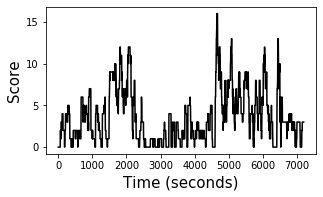

In [70]:
fig = plt.figure(1)
fig.set_size_inches(5, 3)
fig.clear()
fig.subplots_adjust(left=0.15, bottom=0.2)
ax = plt.subplot(111)
# plt.title("Anomaly score over time")
plt.plot(np.arange(dither_proportion.shape[0]), dither_proportion, color='k')

# ax.axhline(y=anomaly_proportion*data.shape[1], color='r', linestyle='--', alpha=0.6)
# ax.text(x=0.15*len(data), y=anomaly_proportion*data.shape[1], s=r'$\theta * N$', 
#         fontsize=15, horizontalalignment='right', verticalalignment='bottom')
# ax.axvline(x=start_time, linestyle='-.', color='r', alpha=0.6)
# ax.axvline(x=start_time-400, linestyle='-.', color='b', alpha=0.6)
# ax.text(x=start_time-400, y=anomaly_proportion*data.shape[1]+0.1, s=r'$L_{pre}$', 
#         fontsize=15, horizontalalignment='right', verticalalignment='bottom')
# ax.axvline(x=start_time+400, linestyle='-.', color='b', alpha=0.6)
# ax.text(x=start_time+400, y=anomaly_proportion*data.shape[1]+0.1, s=r'$L_{post}$', 
#         fontsize=15, horizontalalignment='left', verticalalignment='bottom')
# plt.xlim(0, data.shape[0])

plt.xlabel("Time (seconds)", fontsize=15)
plt.ylabel("Score", fontsize=15)
# plt.savefig(
#             os.path.join(dir_output, "anomaly-score-L{}.png".format(data.shape[0])), dpi=400
#         )

### All MStd Plot

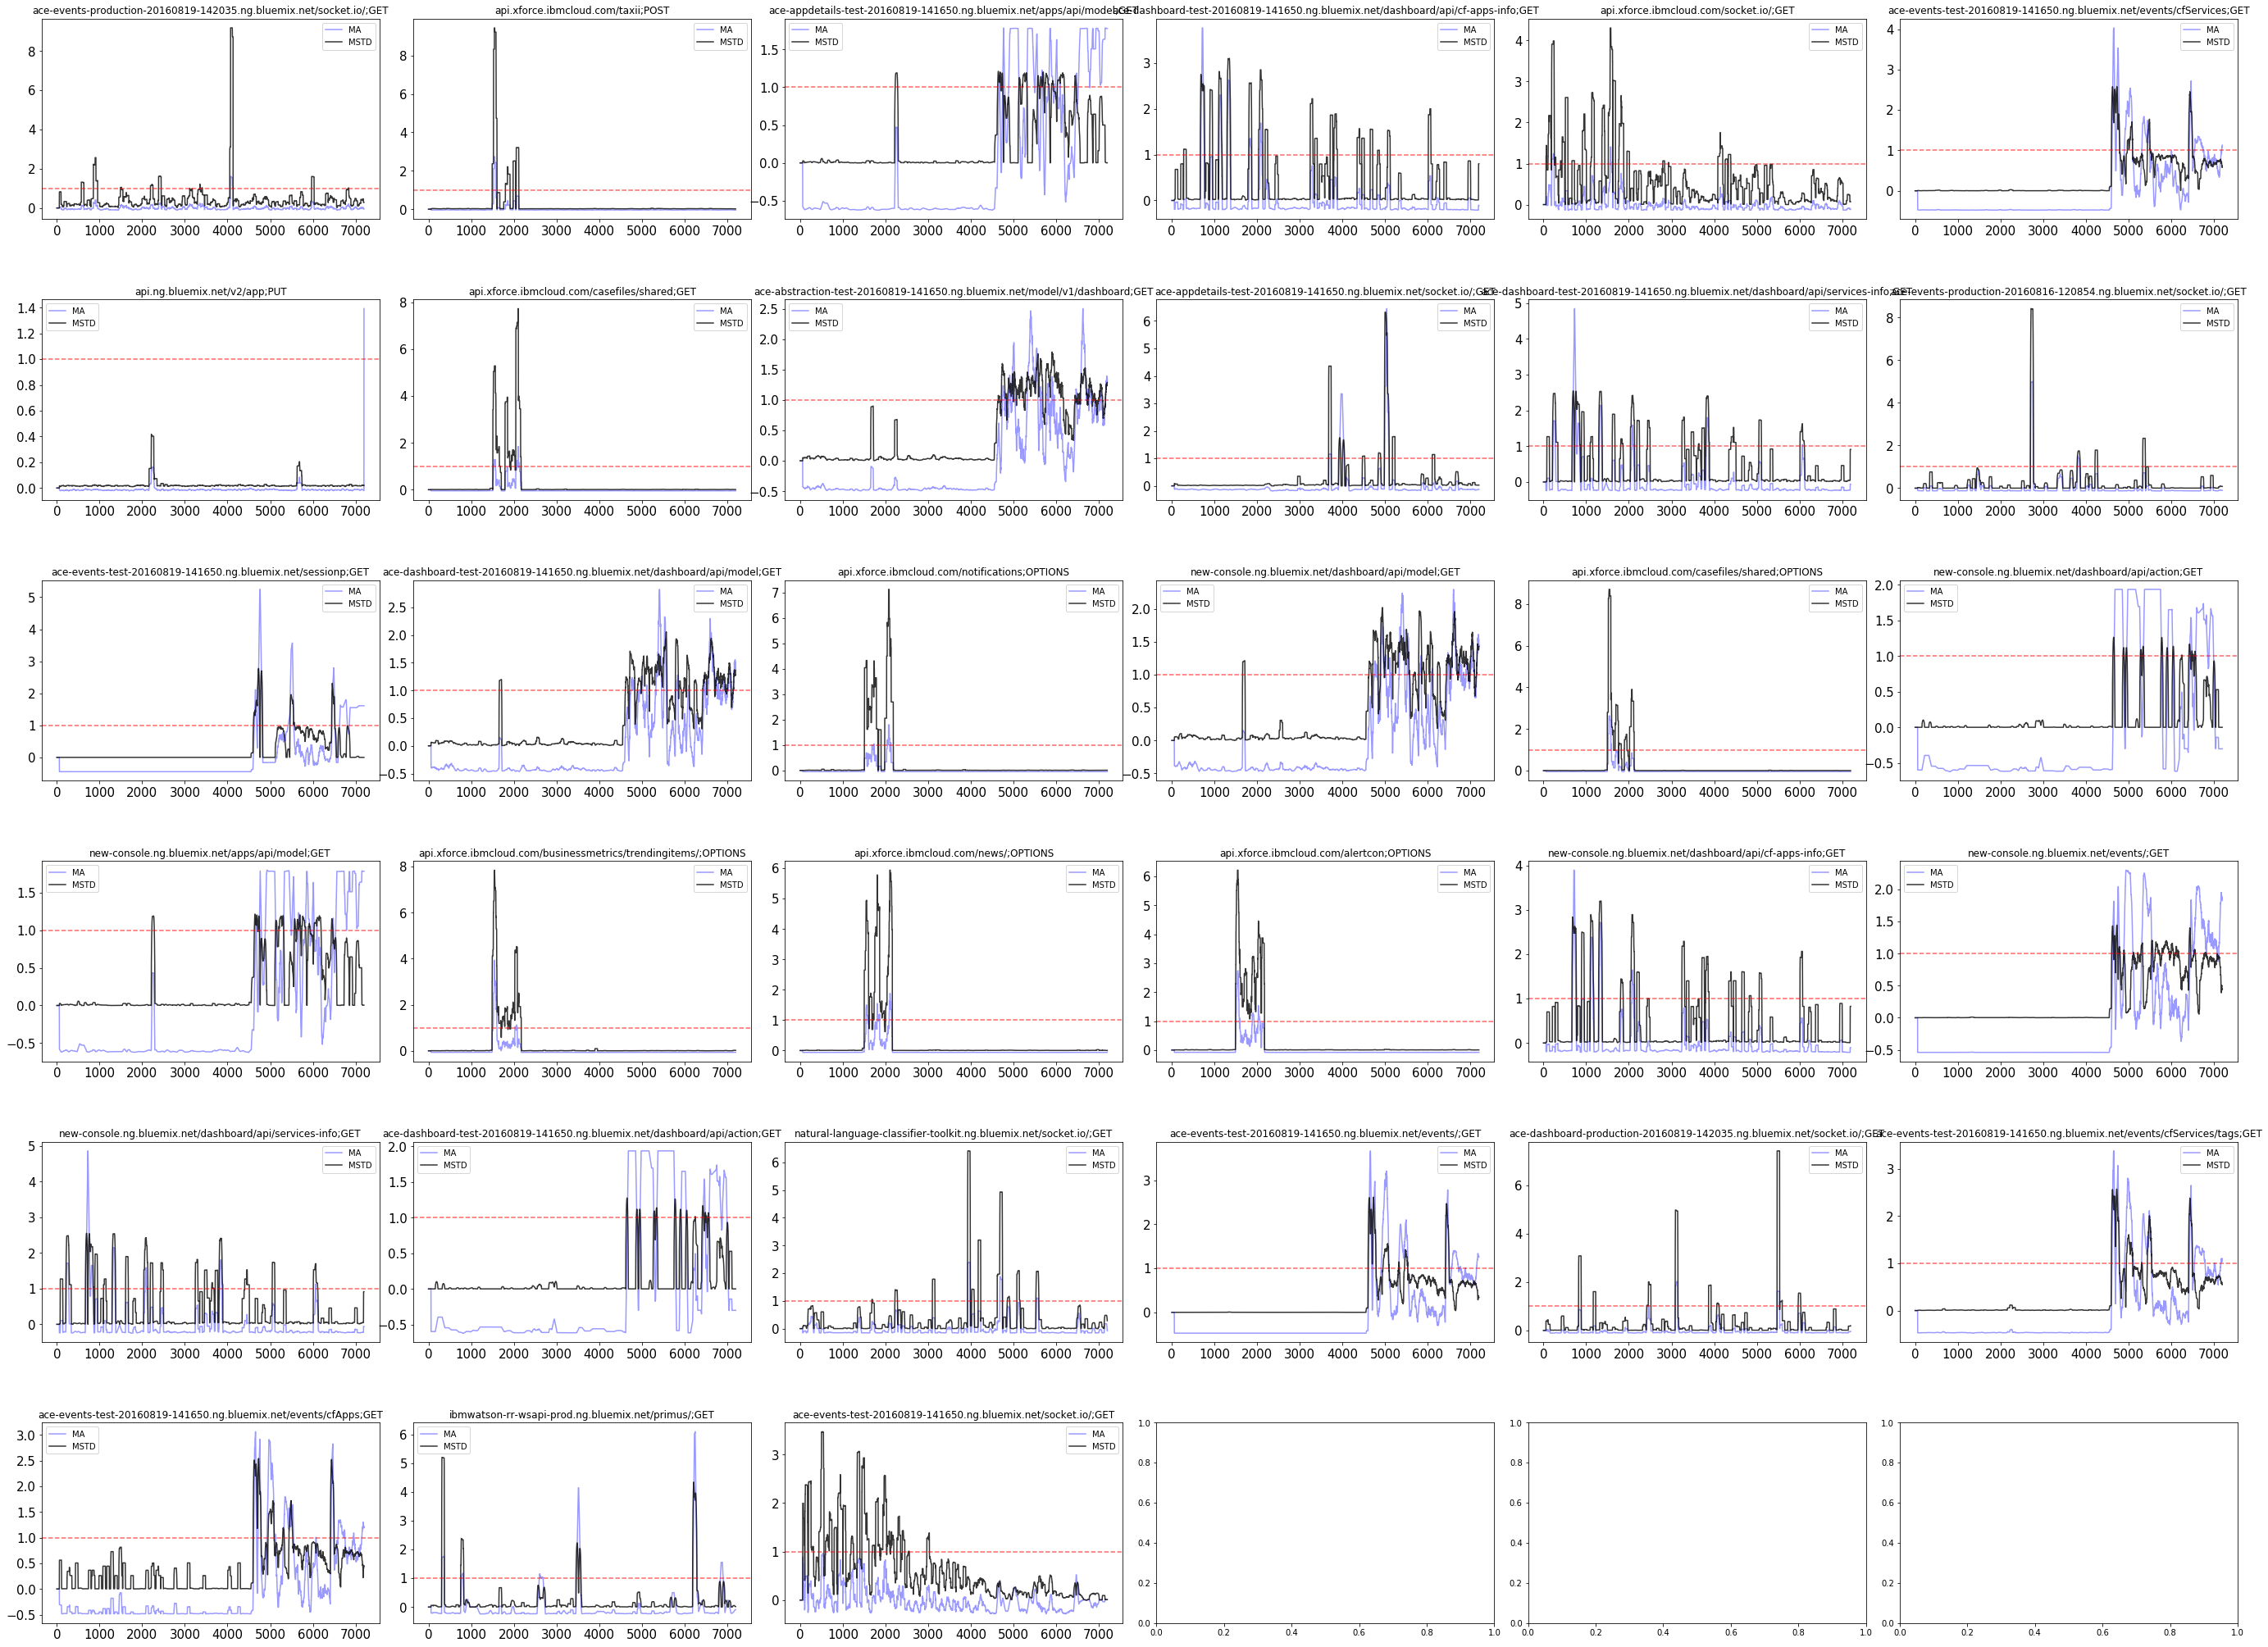

In [17]:
fig = plt.figure(1)
nrows = int(np.sqrt(data.shape[1])) + 1
fig.set_size_inches(nrows * 8, nrows * 6)
fig.clear()
axs = fig.subplots(nrows, nrows)
fig.subplots_adjust(wspace=0.1, hspace=0.4)
for i in range(data.shape[1]):
    ax = axs[i//nrows][i%nrows]
    ax.plot(range(data_ma.shape[0]), data_ma[:, i], color="b", alpha=0.4, label="MA")
    ax.plot(range(data_std.shape[0]), data_std[:, i], color="k", alpha=0.8, label="MSTD")
    ax.axhline(1.0, xmin=0, xmax=1, alpha=0.6, color="r", linestyle="--")
#     ax.set_title('Service '+str(i + 1), fontdict={"fontsize": 15})
    ax.set_title(data_head[i], fontdict={"fontsize": 12})
    ax.tick_params(axis='both', labelsize=15)
    ax.legend()
plt.savefig(
    os.path.join(dir_output, "mastd-data-L{}.png".format(data.shape[0])),
    dpi=300,
)

## Calculate granger intervals

In [75]:
# region Set start time in data to analyze if not provided
anomaly_score = 'Not calculated'
if start_time is None:
    start_time, anomaly_score = anomaly_detect(
        data,
        weight=1,
        mean_interval=50,
        anomaly_proportion=0.3,
        verbose=verbose,
        save_fig=(plot_figures is True) or (isinstance(plot_figures, list) and 'anomaly-score' in plot_figures),
        path_output=dir_output,
    )
if verbose:
    print(
        "{space:^10}{name1:<30}: {}\n"
        "{space:^10}{name2:<30}: {}".format(
            start_time,
            anomaly_score,
            space="",
            name1="Start time",
            name2="Abnormal score",
        )
    )
# endregion

# Manually override settings
# before_length=0
# after_length=200

# region Run loop_granger to get the all intervals
if verbose:
    print("{:-^80}".format("Running Granger Intervals"))
local_length = before_length + after_length
local_data = data[start_time - before_length : start_time + after_length, :]
method = "fast_version_3"
trip = -1
simu_real = "simu"
max_segment_len = before_length + after_length
# max_segment_len = 300
min_segment_len = step
list_segment_split = get_segment_split(before_length + after_length, step)


local_results_file_path = os.path.join(
    dir_output,
    "local-results",
    "aggregate-{}".format(aggre_delta),
    "local_results"
    "_start{start}_bef{bef}_aft{aft}_lag{lag}_sig{sig}_step{step}_min{min}_max{max}.pkl".format(
        start=start_time,
        bef=before_length,
        aft=after_length,
        lag=lag,
        sig=significant_thres,
        step=step,
        min=min_segment_len,
        max=max_segment_len,
    ),
)
if os.path.exists(local_results_file_path):
    print(
        "{:^10}".format("") + "Loading previous granger interval results:",
        os.path.basename(local_results_file_path),
    )
    with open(local_results_file_path, "rb") as f:
        local_results = pickle.load(f)
else:
    print(
        "{space:^10}{name}:\n"
        "{space:^15}bef len      :{bef}\n"
        "{space:^15}aft len      :{aft}\n"
        "{space:^15}lag          :{lag}\n"
        "{space:^15}significant  :{sig}\n"
        "{space:^15}step         :{step}\n"
        "{space:^15}min len      :{min}\n"
        "{space:^15}max len      :{max}\n"
        "{space:^15}segment split:".format(
            space="",
            name="Calculating granger intervals",
            bef=before_length,
            aft=after_length,
            lag=lag,
            sig=significant_thres,
            step=step,
            min=min_segment_len,
            max=max_segment_len,
        ),
        list_segment_split,
    )
    local_results = defaultdict(dict)

    def granger_process(x, y):
        try:
            ret = loop_granger(
                local_data,
                data_head,
                dir_output,
                data_head[x],
                data_head[y],
                significant_thres,
                method,
                trip,
                lag,
                step,
                simu_real,
                max_segment_len,
                min_segment_len,
                verbose=False,
                return_result=True,
            )
        except Exception as e:
            print("Exception occurred at {} -> {}!".format(x, y), e)
            ret = (None, None, None, None, None)
        return ret

    # region ThreadPoolExecuter version
    finished_thread_num = [0]
    lock = threading.Lock()
    total_thread_num = [len(data_head) * (len(data_head) - 1)]
    thread_results = [0 for i in range(total_thread_num[0])]

    pbar = tqdm(total=total_thread_num[0], ascii=True)

    def thread_func(i, x, y):
        # if verbose:
        #     print('Thread {} started'.format(i))
        thread_results[i] = granger_process(x, y)
        lock.acquire()
        finished_thread_num[0] = finished_thread_num[0] + 1
        percent = finished_thread_num[0] / total_thread_num[0]
        # print('{:^15}Thread {} finished, Percent:{:.1f}%'
        #       .format('', i,
        #               percent*100.0))
        lock.release()
        pbar.update(1)
        return

    executor = ThreadPoolExecutor(max_workers=6)
    i = 0
    for x_i in range(len(data_head)):
        for y_i in range(len(data_head)):
            if x_i == y_i:
                continue
            executor.submit(thread_func, i, x_i, y_i)
            i = i + 1
    executor.shutdown(wait=True)
    pbar.close()
    i = 0
    for x_i in range(len(data_head)):
        for y_i in range(len(data_head)):
            if x_i == y_i:
                continue
            (
                total_time,
                time_granger,
                time_adf,
                array_results_YX,
                array_results_XY,
            ) = thread_results[i]
            matrics = [array_results_YX, array_results_XY]
            ordered_intervals = get_ordered_intervals(
                matrics, significant_thres, list_segment_split
            )
            local_results["%s->%s" % (x_i, y_i)]["intervals"] = ordered_intervals
            local_results["%s->%s" % (x_i, y_i)]["result_YX"] = array_results_YX
            local_results["%s->%s" % (x_i, y_i)]["result_XY"] = array_results_XY
            i = i + 1
    # endregion
    os.makedirs(os.path.dirname(local_results_file_path), exist_ok=True)
    with open(local_results_file_path, "wb") as f:
        pickle.dump(local_results, f)
# endregion

          Loading previous granger interval results: local_results_start4653_bef300_aft300_lag10_sig0.1_step60_min60_max600.pkl


## Backtrace Root Cause Analysis

In [76]:
def temporal_dynamics_discovery(local_results, num, plot_figures=False, verbose=False):
    # Generate dynamic causal curve between two services by overlaying intervals
    overlay_result = {}
    for x_i in range(len(data_head)):
        for y_i in range(len(data_head)):
            if y_i == x_i:
                continue
            key = "{0}->{1}".format(x_i, y_i)
            intervals = local_results[key]["intervals"]
            overlay_counts = get_overlay_count(local_length, intervals)
            overlay_result[key] = overlay_counts
            # whether plot temporaray figure pair wise
            if (plot_figures is True) or (isinstance(plot_figures, list) and 'dycurves' in plot_figures):
                os.makedirs(os.path.join(dir_output, "dynamic-causal-curves"), exist_ok=True)
                if verbose:
                    print(
                        "{:^10}Ploting {:2d}->{:2d}".format("", x_i + 1, y_i + 1), end="\r"
                    )
                draw_overlay_histogram(
                    overlay_counts,
                    "{}->{}".format(x_i + 1, y_i + 1),
                    os.path.join(
                        dir_output, "dynamic-causal-curves", "{0}-{1}.png".format(x_i + 1, y_i + 1)
                    ),
                )
    # skip the \r print line
    if (plot_figures is True) or (isinstance(plot_figures, list) and 'dycurves' in plot_figures) and verbose:
        print("")
    return overlay_result


overlay_result = temporal_dynamics_discovery(local_results, len(data_head), plot_figures=plot_figures, verbose=verbose)


def adaptive_thresholding(overlay_result, edge_threshold, adaptive=True, 
                          plot_figures=False, dir_output='.', verbose=False):
    """ Make edges from 1 node using auto thresholding
    
    Params:
        overlay_result: dynamic causality curves in dict
        edge_threshold: static or adaptive threshold value
        adaptive: whether adaptive
    """ 
    edge_weight = dict()
    for x_i in range(len(data_head[:])):
        bar_data = []
        for y_i in range(len(data_head)):
            key = "{0}->{1}".format(x_i, y_i)
            if x_i != y_i:
                bar_data.append(sum(overlay_result[key]))
            else:
                bar_data.append(0.0)
        # whether plot temporary figure from one node
        if (plot_figures is True) or (isinstance(plot_figures, list) and 'aggre-imgs' in plot_figures):
            if not os.path.exists(os.path.join(dir_output, "aggre-imgs")):
                os.makedirs(os.path.join(dir_output, "aggre-imgs"))
            if verbose:
                print("{:^10}Ploting aggre imgs {:2d}".format("", x_i + 1), 
                        end="\r")
            draw_bar_histogram(
                bar_data, auto_threshold_ratio, 
                "From service {0}".format(x_i + 1),
                os.path.join(dir_output, "aggre-imgs", "From {0}.png".format(x_i + 1)),
            )
        bar_data_thres = np.max(bar_data) * edge_threshold if adaptive else edge_threshold
        for y_i in range(len(data_head)):
            if bar_data[y_i] >= bar_data_thres:
                edge_weight[(x_i, y_i)] = bar_data[y_i]          
    # skip the \r print line
    if (plot_figures is True) or (isinstance(plot_figures, list) and 'aggre-imgs' in plot_figures) and verbose:
        print("")
    return edge_weight


# edge_weight = adaptive_thresholding(overlay_result, auto_threshold_ratio, 
#                                     adaptive=True, plot_figures=plot_figures, dir_output=dir_output, verbose=verbose)


def construct_impact_graph(local_results, num, auto_threshold_ratio, adaptive=True,
                           plot_figures=False, verbose=False, dir_output='.'):
    """ The whole construction of impact graph
    """
    overlay_result = temporal_dynamics_discovery(
        local_results, num, plot_figures=plot_figures, verbose=verbose
    )
    edge_weight = adaptive_thresholding(overlay_result, auto_threshold_ratio, 
                                    adaptive=adaptive, plot_figures=plot_figures, dir_output=dir_output, verbose=verbose)
    # Make the transition matrix with edge weight estimation
    transition_matrix = np.zeros([num, num])
    for key, val in edge_weight.items():
        x, y = key
        transition_matrix[x, y] = val
    transition_matrix = normalize_by_column(transition_matrix)
    # transition_matrix = normalize_by_row(transition_matrix)
    return transition_matrix
    
    
transition_matrix = construct_impact_graph(local_results, len(data_head), auto_threshold_ratio, adaptive=True,
                                           plot_figures=[], dir_output=dir_output, verbose=True)
    
    
def save_graph_excel(filename_prefix, matrix):
    common_suffix = "-bef{}-aft{}-step{}-lag{}-thres{}".format(
        before_length,
        after_length,
        step,
        lag, auto_threshold_ratio)
    if (plot_figures is True) or (isinstance(plot_figures, list) and 'graph' in plot_figures):
        draw_weighted_graph(
            matrix,
            os.path.join(
                dir_output,
                filename_prefix + common_suffix+".png",
            ),
            weight_multiplier=4,
        )
    saveToExcel(
        os.path.join(
            dir_output,
            filename_prefix + common_suffix+".xlsx",
        ),
        matrix.tolist(),
    )

save_graph_excel("graph", transition_matrix)


def root_cause_analysis(transition_matrix, frontend, true_root_cause, 
                        testrun_round, local_data, mean_method, max_path_length, topk_path, num_sel_node,
                        verbose=False, ret_result=False):
    if verbose:
        print("{:-^80}".format("Back trace root cause analysis phase"))
    topk_list = range(1, 6)
    prkS = [0] * len(topk_list)
    if not isinstance(frontend, list):
        frontend = [frontend]
    for entry_point in frontend:
        if verbose:
            print("{:*^40}".format(" Entry: {:2d} ".format(entry_point)))
        prkS_list = []
        acc_list = []
        for i in range(testrun_round):
            ranked_nodes, new_matrix = analyze_root(
                transition_matrix,
                entry_point,
                local_data,
                mean_method=mean_method,
                max_path_length=max_path_length,
                topk_path=topk_path,
                prob_thres=0.2,
                num_sel_node=num_sel_node,
                use_new_matrix=False,
                verbose=verbose,
            )
            if verbose:
                print("{:^0}|{:>8}|{:>12}|".format("", "Node", "Score"))
                for j in range(len(ranked_nodes)):
                    print(
                        "{:^0}|{:>8d}|{:>12.7f}|".format(
                            "", ranked_nodes[j][0], ranked_nodes[j][1]
                        )
                    )
            prkS = pr_stat(ranked_nodes, true_root_cause)
            acc = my_acc(ranked_nodes, true_root_cause, local_data.shape[1])
            prkS_list.append(prkS)
            acc_list.append(acc)
        prkS = np.mean(np.array(prkS_list), axis=0).tolist()
        acc = float(np.mean(np.array(acc_list)))
        if 'disable_print' not in kws or kws['disable_print'] is False:
            print_prk_acc(prkS, acc)
    if ret_result:
        return prkS, acc, ranked_nodes
    else:
        return prkS, acc


prks, acc, ranked_nodes = root_cause_analysis(transition_matrix, frontend, true_root_cause, 
                    testrun_round, local_data, mean_method, max_path_length, topk_path, num_sel_node,
                    verbose=verbose, ret_result=True)

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.6667  0.7500  1.0000    0.5833  0.9924


In [77]:
from dycause_lib.randwalk import randwalk

epoch=1000000

max_path_length=None
prob_thres=0.0

prob_path, new_matrix = randwalk(
        transition_matrix,
        epoch=epoch,
        mean_method=mean_method,
        max_path_length=max_path_length,
        entry_point=frontend[0],
        use_new_matrix=False,
        verbose=False,
)
print('Number of out path : ', len(prob_path))
# Reverse nodes in path
path_list = [list(reversed(i[1])) for i in prob_path]
path_list = [[i for i in path]for path in path_list]
path_list[:20]

Number of out path :  10001


[[27, 5, 13],
 [27, 5, 8, 26, 21, 20, 13],
 [27, 5, 8, 26, 16, 11, 28, 32, 1, 21, 20, 13],
 [27, 5, 8, 26, 21, 14, 22, 2, 20, 13],
 [27, 5, 8, 26, 21, 14, 3, 10, 9, 0, 20, 13],
 [27, 5, 8, 26, 21, 14, 3, 24, 9, 0, 20, 13],
 [29, 13],
 [4, 0, 26, 21, 20, 13],
 [4, 26, 21, 20, 13],
 [27, 5, 8, 26, 6, 11, 28, 32, 1, 21, 20, 13],
 [27, 5, 8, 26, 21, 16, 11, 28, 32, 1, 20, 13],
 [27, 5, 8, 26, 21, 14, 22, 18, 2, 20, 13],
 [27, 5, 8, 26, 16, 11, 28, 32, 1, 20, 13],
 [27, 5, 8, 26, 21, 14, 3, 9, 0, 20, 13],
 [27, 5, 8, 26, 21, 14, 22, 9, 0, 20, 13],
 [4, 0, 26, 16, 11, 28, 32, 1, 21, 20, 13],
 [27, 5, 8, 26, 21, 14, 3, 10, 9, 0, 2, 20, 13],
 [27, 5, 8, 26, 21, 14, 3, 24, 9, 0, 2, 20, 13],
 [4, 26, 16, 11, 28, 32, 1, 21, 20, 13],
 [4, 26, 21, 14, 3, 10, 9, 0, 20, 13]]

## Dynamic causal curve plot

### Colored dynamic curves plot. Example in paper(Figure 5)

In [78]:
path = path_list[36]
['{:<31}'
 .format(data_head[path[i]])
    for i in range(len(path))]

['ace-events-test-20160819-141650.ng.bluemix.net/events/;GET',
 'ace-abstraction-test-20160819-141650.ng.bluemix.net/model/v1/dashboard;GET',
 'natural-language-classifier-toolkit.ng.bluemix.net/socket.io/;GET',
 'api.xforce.ibmcloud.com/alertcon;OPTIONS',
 'api.xforce.ibmcloud.com/news/;OPTIONS',
 'ace-dashboard-test-20160819-141650.ng.bluemix.net/dashboard/api/model;GET']

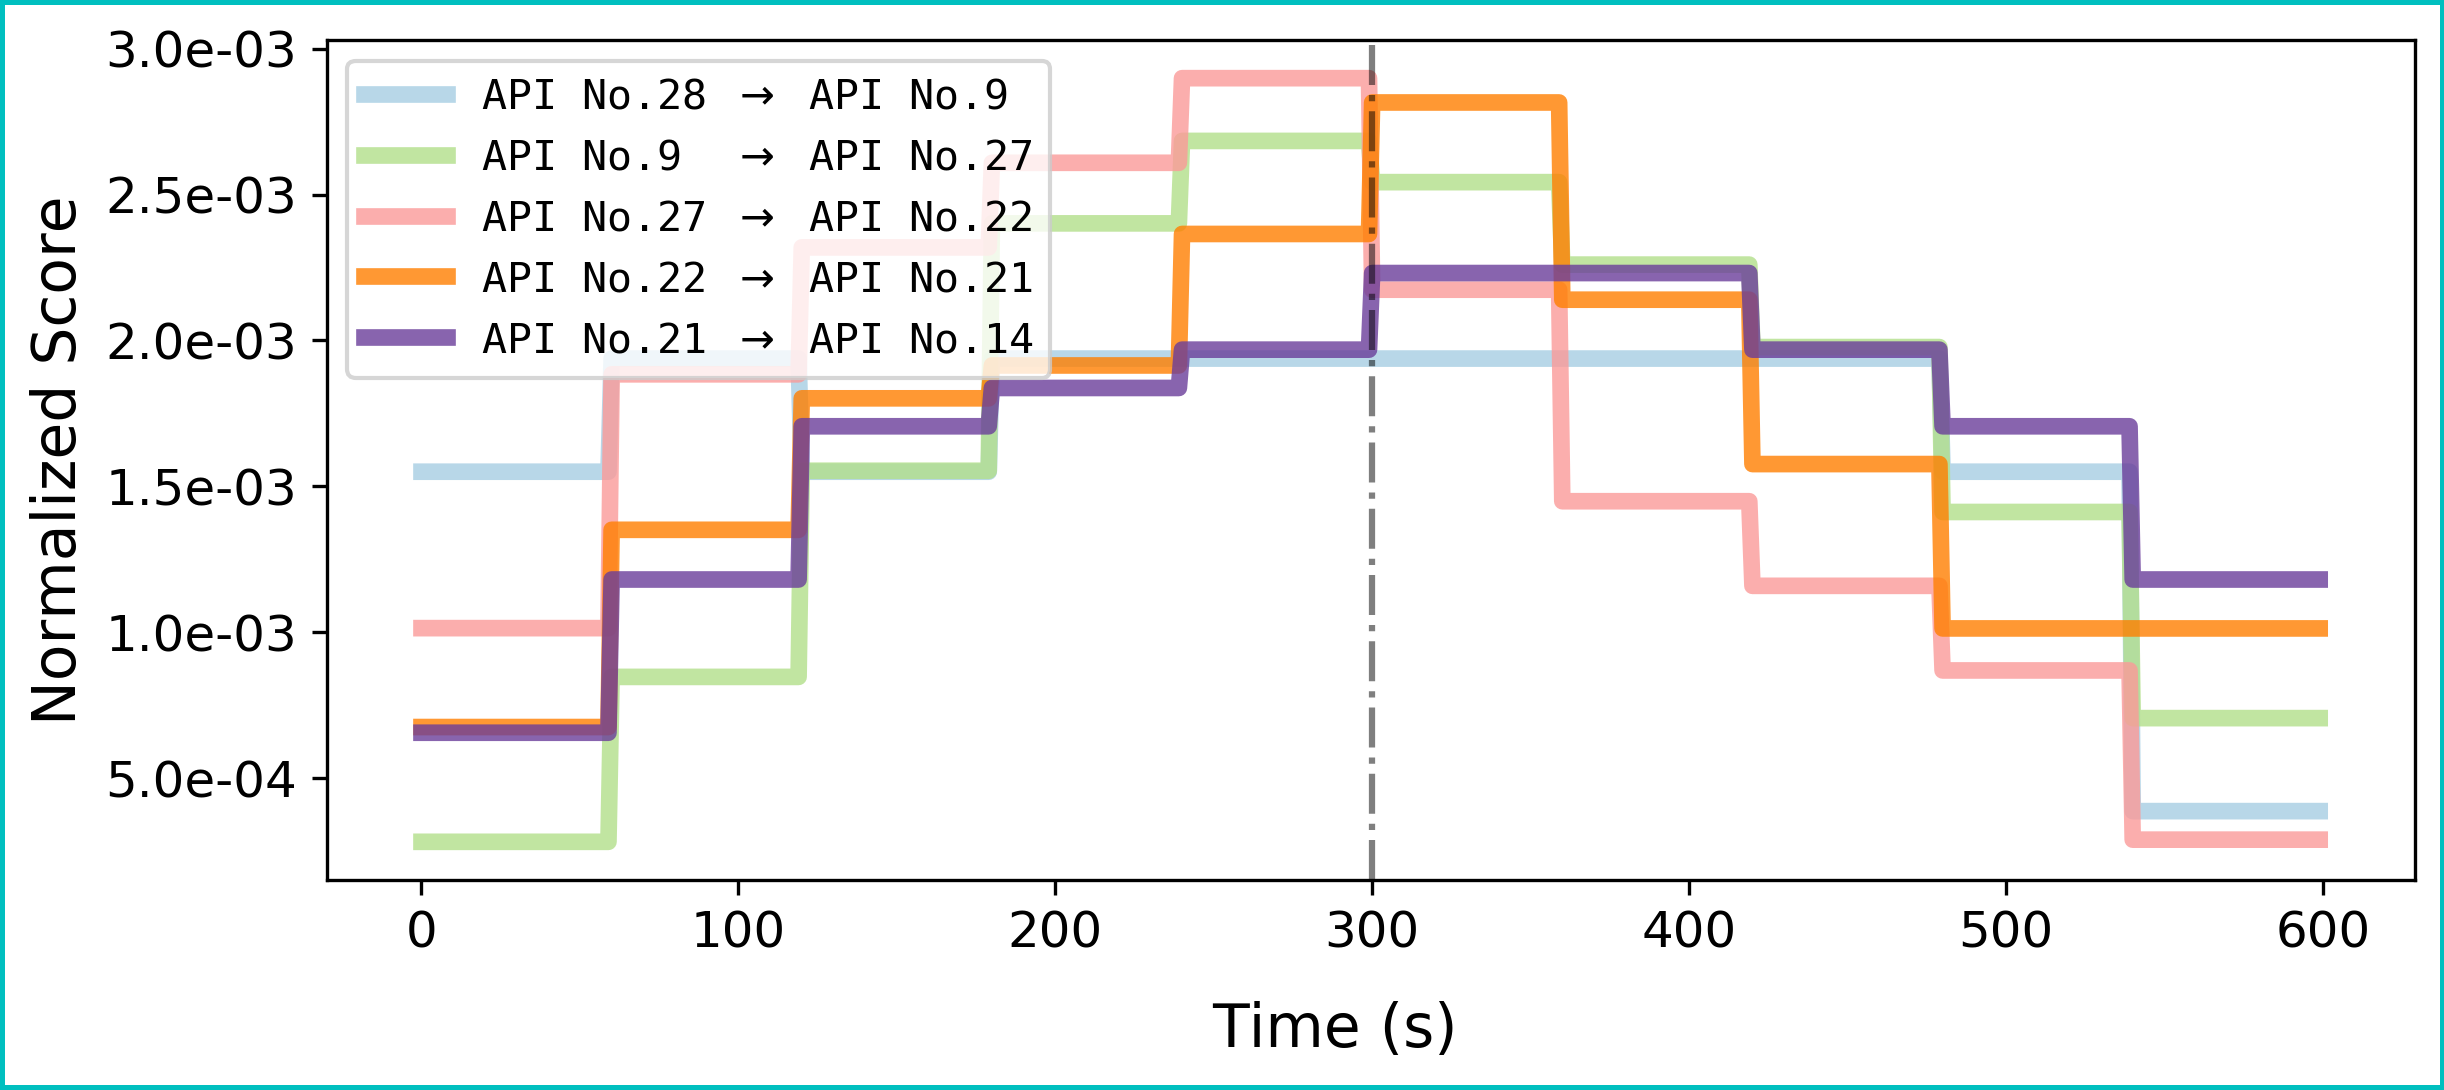

In [28]:
# path=[29, 15, 19, 9, 10]
def plot_path_dycausal_curves(path, savepath=False):
    fontsize='x-large'
    fig = plt.figure(1, edgecolor='c', linewidth=2, dpi=300)
    fig.set_size_inches(8, 4)
    fig.clear()
    fig.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.2, wspace=0.2, hspace=0.35)
    ax = fig.subplots(1, 1)
    seq_cmap = plt.get_cmap('Paired')
#     seq_cmap = plt.get_cmap('Greys')
    keys = ['{}->{}'.format(path[i], path[i+1]) for i in range(len(path)-1)]
#     titles = ['{:<31} $\\rightarrow$ {}'
#               .format(simplified_data_head[path[i]], simplified_data_head[path[i+1]])
#                for i in range(len(path)-1)]
    titles = [
        'API No.{:<2} $\\rightarrow$ API No.{}'
        .format(path[i]+1, path[i+1]+1) for i in range(len(path)-1)
    ]
    max_score = 0.0
    for i, key in enumerate(keys):
        ax.plot(range(np.array(overlay_result[key]).shape[0]), overlay_result[key]/np.sum(overlay_result[key]), 
                color=seq_cmap(i/len(keys)), 
                linewidth=4, label=titles[i], alpha=0.8)
        max_score = np.max(overlay_result[key]) if np.max(overlay_result[key]) > max_score else max_score
    ax.axvline(before_length, color='k', linestyle='-.', alpha=0.5)
    from matplotlib.ticker import StrMethodFormatter
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1e}'))
    ax.tick_params(axis='both', labelsize='large')
    ax.set_ylabel('Normalized Score', fontsize=fontsize)
#     ax.set_ylabel('归一化的关联强度', fontsize=fontsize)
    ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=9, prop={'family': 'monospace'})
    fig.text(x=0.5, y=0.05, s='Time (s)', fontsize=fontsize,
             horizontalalignment='center', verticalalignment='bottom')
#     fig.text(x=0.5, y=0.05, s='时间(秒)', fontsize=fontsize,
#              horizontalalignment='center', verticalalignment='bottom')
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, dpi=fig.dpi, bbox_inches='tight')
    return

plot_path_dycausal_curves(path_list[36], None)

## Adaptive thresholding algorithm

### Common functions

In [9]:
def get_bar_heights(result_dict):
#     heights_array = [[] for i in range(len(next(iter(result_dict.values()))['prks'])+1)]
    heights_array = [[] for i in range(2)]
    for key, result in result_dict.items():
        prks, acc = result['prks'], result['acc']
#         for j, prk in enumerate(prks):
#             heights_array[j].append(prk)
        heights_array[0].append(np.mean(prks))
#         heights_array[len(prks)].append(acc)
        heights_array[1].append(acc)
    return heights_array


def draw_stacked_bar(bar_xlabels, heights_array, savename=False, ax=None, xlabel_format='{:.2f}', num_xlabels=None, 
                     draw_bar_height=True, xlabel=None, bar_labels=['PR@Avg', 'RankScore'], bar_step=1.0, fontsize='x-large'):
    xlabels = np.array([xlabel_format.format(i) for i in bar_xlabels])
#     bar_labels = ['PR@{}'.format(i) for i in range(1, 6)] + ['Acc']

    if ax is None:
        fig = plt.figure(figsize=[8, 4], dpi=300)
        ax = fig.subplots(1, 1)


    x=np.arange(0, (len(xlabels))*bar_step, bar_step)
    width = (bar_step*0.8)/len(heights_array)

    cmap=plt.get_cmap('Paired')
    cmap_inds = [i/len(heights_array) for i in range(len(heights_array))]
#     cmap=plt.get_cmap('tab20')
#     cmap_inds = [0.0, 4/20]
    rect_list = []
    for i, heights in enumerate(heights_array):
        if bar_labels is not None and len(bar_labels) == len(heights_array):
            rect_list.append(ax.bar(x+width*i, heights, width=width, align='edge', color=cmap(cmap_inds[i]), 
                            label=bar_labels[i]))
        else:
            rect_list.append(ax.bar(x+width*i, heights, width=width, align='edge', color=cmap(cmap_inds[i]), 
                            ))

#     ax.set_ylabel('PR@K or Acc', fontsize=fontsize)
#     ax.set_ylim(0.0, 1.0+0.2)
#     ax.set_xlabel('$\\theta_e$', fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize='xx-large')
    
    if num_xlabels is None:
        num_xlabels = len(xlabels)
    xlabel_tick_inds = np.arange(len(xlabels))[::int(len(xlabels)/num_xlabels)]
    ax.set_xticks((x+0.5*width*len(heights_array))[xlabel_tick_inds])
    ax.set_xticklabels(xlabels[xlabel_tick_inds], rotation=0)
    ax.set_xlim(0, x[-1]+bar_step)
    ax.tick_params(labelsize=fontsize, axis='both')
    
    import matplotlib.lines as mlines
    from matplotlib.patches import Circle
    lines = rect_list
#     lines.extend([
#         mlines.Line2D([], [], linestyle='--', 
#             marker='o', color='k', label='Runtime')
#     ])
    if len(lines)>0 and bar_labels is not None:
        ax.legend(handles=lines, loc='upper left', fontsize=fontsize, framealpha=0.5)
#     ax.legend(loc='upper left', fontsize=fontsize)

    if draw_bar_height:
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
        #         ax.annotate('{:.2f}'.format(height),
        #                     xy=(rect.get_x() + rect.get_width() / 2, height),
        #                     xytext=(0, 3),  # 3 points vertical offset
        #                     textcoords="offset points",
        #                     ha='center', va='bottom', fontsize=6)
                ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, '{:.2f}'.format(height), 
                        ha='center', va='bottom', fontsize=12)

        for rect in rect_list:
            autolabel(rect)
    if ax is None:
        fig.tight_layout()
        if savename:
            plt.savefig(savename)
        plt.show()

### Test adaptive threshold value

In [32]:
adaptive_thresholds = np.arange(0.1, 1.1, 0.1)

#### Run tests and record to file

In [ ]:
result_dict = {}
for threshold in adaptive_thresholds:
    transition_matrix = construct_impact_graph(local_results, len(data_head), threshold, adaptive=True,
                                           plot_figures=plot_figures, dir_output=dir_output, verbose=verbose)
    prks, acc = root_cause_analysis(transition_matrix, frontend, true_root_cause, 
                    testrun_round, local_data, mean_method, max_path_length, topk_path, num_sel_node,
                    verbose=verbose)
    result_dict[threshold]= {'prks': prks, 'acc': acc}
with open(os.path.join(dir_output, 'threshold-exps', 'adaptive-threshold-result.pkl'), 'wb') as f:
    pickle.dump(result_dict, f)  

#### Load previous test results

In [30]:
with open(os.path.join(dir_output, 'threshold-exps', 'adaptive-threshold-result.pkl'), 'rb') as f:
    adaptive_result_dict = pickle.load(f)
heights_array = get_bar_heights(adaptive_result_dict)
pprint.pprint(heights_array)

[[0.4666666666666666,
  0.4666666666666666,
  0.5333333333333333,
  0.31666666666666665,
  0.31666666666666665,
  0.9,
  0.5833333333333333,
  0.9,
  0.7333333333333333,
  0.4666666666666666],
 [0.25,
  0.25,
  0.75,
  0.7424242424242424,
  0.7424242424242424,
  0.75,
  0.9924242424242424,
  0.75,
  0.5,
  0.25]]


### Test static threshold value

In [34]:
static_thresholds = np.arange(1000, 11000, 1000)

#### Run tests and record to file

In [35]:
static_result_dict = {}
for threshold in static_thresholds:
    transition_matrix = construct_impact_graph(local_results, len(data_head), threshold, adaptive=False,
                                           plot_figures=plot_figures, dir_output=dir_output, verbose=verbose)
    prks, acc = root_cause_analysis(transition_matrix, frontend, true_root_cause, 
                    testrun_round, local_data, mean_method, max_path_length, topk_path, num_sel_node,
                    verbose=verbose)
    static_result_dict[threshold]={'prks': prks, 'acc': acc}
with open(os.path.join(dir_output, 'threshold-exps', 'static-threshold-result.pkl'), 'wb') as f:
    pickle.dump(static_result_dict, f)

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
1.0000  0.5000  0.3333  0.2500  0.2500    0.4667  0.2500
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.3333  0.2500  0.2500    0.2667  0.2500
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.6667  0.5000  0.5000    0.4333  0.5000
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.6667  0.7500  0.7500    0.5333  0.7500
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.0000    0.0000  0.0000
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.3333  0.2500 

C:\Users\pyc\Anaconda3\envs\statsenv\lib\site-packages\scipy\stats\stats.py:396: RuntimeWarning: invalid value encountered in double_scalars
  return size / np.sum(1.0 / a, axis=axis, dtype=dtype)


  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
1.0000  0.5000  0.3333  0.2500  0.2500    0.4667  0.2500
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.0000    0.0000  0.0000
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.0000    0.0000  0.0000


#### Load previous test results

In [37]:
with open(os.path.join(dir_output, 'threshold-exps', 'static-threshold-result.pkl'), 'rb') as f:
    static_result_dict = pickle.load(f)
heights_array = get_bar_heights(static_result_dict)
pprint.pprint(heights_array)

[[0.4666666666666666,
  0.26666666666666666,
  0.4333333333333333,
  0.5333333333333333,
  0.0,
  0.26666666666666666,
  0.4666666666666666,
  0.4666666666666666,
  0.0,
  0.0],
 [0.25, 0.25, 0.5, 0.75, 0.0, 0.25, 0.25, 0.25, 0.0, 0.0]]


### Compare thresholding differences (Figure 7)

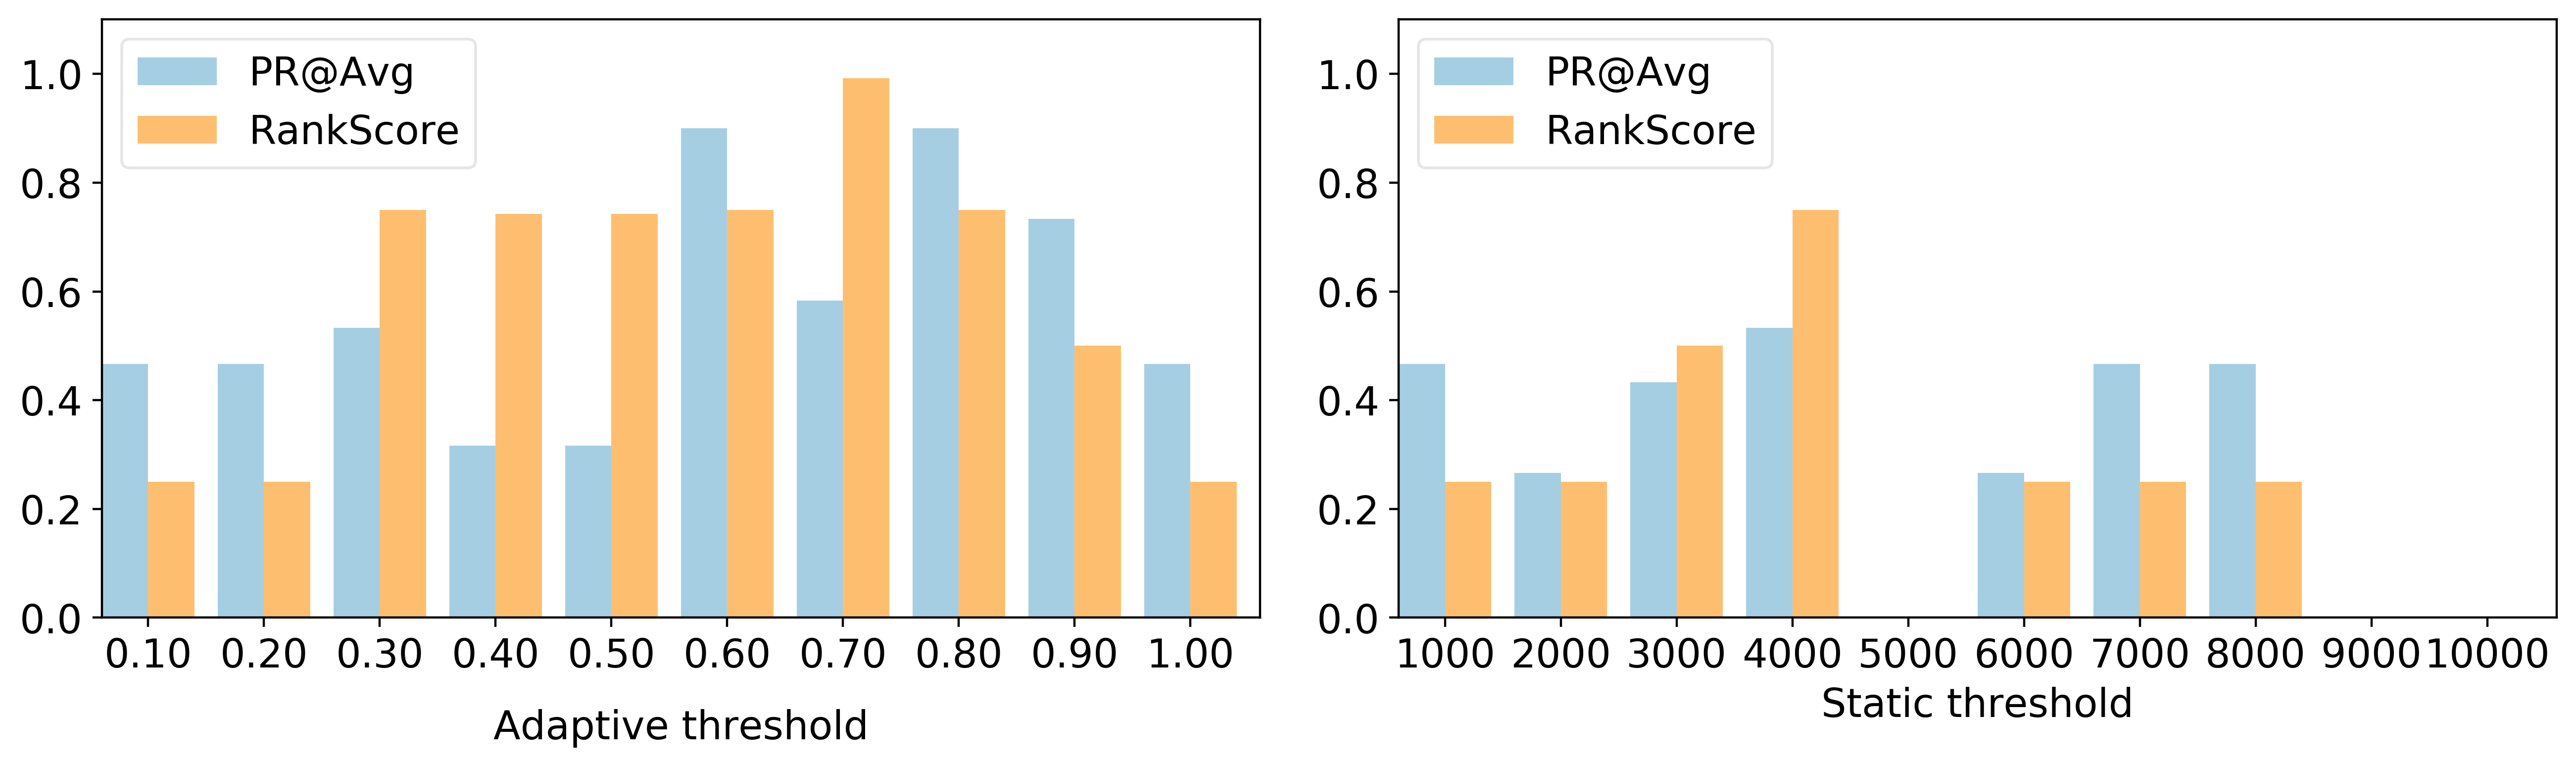

In [38]:
# 1 column 2 rows layout
# fig = plt.figure(figsize=[12, 8], dpi=300)
# axs = fig.subplots(2, 1, gridspec_kw={'hspace': 0.25})

# 2 columns 1 row layout
fig = plt.figure(figsize=[16, 4], dpi=400)
axs = fig.subplots(1, 2, sharey=False)
fig.subplots_adjust(wspace=0.12)

fontsize='x-large'

adaptive_thresholds = np.arange(0.1, 1.1, 0.1)
heights_array = get_bar_heights(adaptive_result_dict)
draw_stacked_bar(adaptive_thresholds, heights_array,
                   ax=axs[0], draw_bar_height=False)
axs[0].set_xlabel('Adaptive threshold', fontsize=fontsize, labelpad=12)
axs[0].set_ylim(0, 1.1)
axs[0].set_yticks(np.arange(0, 1.2, 0.2))

static_thresholds = np.arange(1000, 11000, 1000)
heights_array = get_bar_heights(static_result_dict)
draw_stacked_bar(static_thresholds, heights_array,
                   ax=axs[1], xlabel_format='{:}', draw_bar_height=False)
axs[1].set_xlabel('Static threshold', fontsize=fontsize)
axs[1].set_ylim(0, 1.1)
axs[1].set_yticks(np.arange(0, 1.2, 0.2))
# axs[1].set_yticks([])
name = 'Fig-7-both-threshold-bar-2cols'
# plt.savefig(os.path.join(dir_output, 'threshold-exps', name+'.eps'), bbox_inches='tight')
# plt.savefig(os.path.join(dir_output, 'threshold-exps', name+'.png'), bbox_inches='tight')
plt.show()

## Dependency Graph compare

### Common functions

In [39]:
def draw_weighted_graph(transition_matrix, node_pos=None, weight_multiplier=1, savefig_path=None, ax=None, gt_edges=None,
                       frontend=None, true_rcs=[], title=None, minimum_weight=0.2):
    """Draw weighted graph given transition matrix
    
    The parameter is a transition matrix which the i,j element
    represent the probability of transition from i to j
    The weight is illustrated using edge width
    
    Params:
        transition_matrix: the transition probability matrix
        node_pos: dictionary of node positions, node -> (x, y). If None nodes are scatter along a circle.
        weight_multiplier: multiply normalized weight by this
        savefig_path: the path for saving the output figure, if None don't save figure
        ax: the axes for ploting the graph, if None we will create a new figure and axes.
        gt_edges: the groundtruth edges of causality graph, which will be used to distinguish edges. 
            Black for correct and yellow for missing edges.
        frontend: frontend service in root cause analysis, indicated by yellow nodes.
        true_rcs: list of true root cause services, indicated by red nodes.
        title: title for this axes. None means no title.
        minimum_weight: The minimum weight for edges to be plotted.
    """
    fontsize='x-large'
    node_size=300

    n = len(transition_matrix)
    if ax is None:
        fig = plt.figure(figsize=(8, 8), dpi=300)
        ax = fig.subplots(1, 1)

    if node_pos is None:
        node_pos = dict()
        for i in range(1, n+1):
            angle = (i-1)/n*(2*np.pi)
            node_pos[i] = (np.cos(angle), np.sin(angle))


    def convert_edges(matrix, g):
        for x_i in range(1, n+1):
            for y_i in range(1, n+1):
                if matrix[x_i-1][y_i-1] > minimum_weight:
                    g.add_edge(x_i, y_i)


    g = nx.DiGraph()
    g.add_nodes_from(range(1, n+1))
#     gt_g = nx.DiGraph()
    convert_edges(transition_matrix, g)
    if gt_edges is not None:
        correct_edges = []
        missing_edges = []
        for edge in gt_edges:
            if edge in g.edges():
                g.remove_edge(*edge)
                correct_edges.append(edge)
            else:
                missing_edges.append(edge)
    # convert_edges(gt_matrix, gt_g)

    weight_list = np.array([transition_matrix[key[0]-1, key[1]-1] for key in g.edges()])
#     weight_list = weight_list / np.max(weight_list) * weight_multiplier
    weight_list = weight_list * weight_multiplier

    edge_colors = weight_list / weight_multiplier

#     greys_cmap = plt.get_cmap('Greys')
    greys_cmap = plt.get_cmap('cool')
    # First draw edges
    nx.draw_networkx_edges(g, node_pos, ax=ax, edgelist=g.edges(), alpha=0.9,
                           width=weight_multiplier, edge_color=edge_colors,arrowsize=10, 
                           edge_cmap=greys_cmap, 
                           edge_vmin=0.0, edge_vmax=1.0, 
                           node_size=node_size, linestyle='--')
    
    if gt_edges is not None:
        nx.draw_networkx_edges(g, node_pos, ax=ax, edgelist=correct_edges, alpha=1.0,
                               width=weight_multiplier, edge_color='k',arrowsize=10,
                               node_size=node_size, linestyle='--')
        nx.draw_networkx_edges(g, node_pos, ax=ax, edgelist=missing_edges, alpha=1.0,
                               width=weight_multiplier, edge_color='y',arrowsize=10,
                               node_size=node_size, linestyle='--')
    # Then draw nodes
    default_color_nodes = list(g.nodes())
    if frontend is not None:
        nx.draw_networkx_nodes(g, node_pos, nodelist=[frontend], ax=ax, node_size=node_size,
         node_color='y')
        default_color_nodes.remove(frontend)
    if true_rcs is not None:
        nx.draw_networkx_nodes(g, node_pos, nodelist=true_rcs, ax=ax, node_size=node_size,
         node_color=['r'])
        for i in true_rcs:
            default_color_nodes.remove(i)
    nx.draw_networkx_nodes(g, node_pos, nodelist=default_color_nodes, ax=ax, node_size=node_size,
         node_color='gray')
    nx.draw_networkx_labels(g, node_pos, labels={i: str(i) for i in range(1, n+1)}, font_size=fontsize,
                           font_color='k', ax=ax)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(True)
    
    import matplotlib.lines as mlines
    from matplotlib.patches import Circle
    lines = [
#         mlines.Line2D([], [], color='k', label='Correct'),
#         mlines.Line2D([], [], color='y', label='Missing'),
    ]
    if frontend is not None:
        lines.append(mlines.Line2D([], [], marker='o', markeredgewidth=5, linestyle='', color=greys_cmap(0.4), label='Frontend'))
    if len(true_rcs) > 0:
        lines.append(mlines.Line2D([], [], marker='o', markeredgewidth=5, linestyle='', color=greys_cmap(0.6), label='Root causes'))
    if len(lines)>0:
        ax.legend(handles=lines, loc='upper left', fontsize=fontsize)
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if savefig_path is not None:
        # Create directory if not exists
        if not os.path.exists(os.path.dirname(savefig_path)):
            os.makedirs(os.path.dirname(savefig_path))
        plt.savefig(savefig_path)
    # plt.show()
    return

### PC Graph

The graph lacks essential edges to the frontend service and thus no possible backtrace paths could 
be found. The accuracy and PR@k is 0.

In [102]:
from cloud_ranger.get_link_matrix import build_graph_pc

pc_trans_matrix_dict = {}
for alpha in np.arange(0.1, 0.2, 0.1):
    print('PC Alpha: {}'.format(alpha))
    pc_trans_matrix = build_graph_pc(local_data.T, alpha=alpha)
    pc_trans_matrix = np.array(pc_trans_matrix)
    pc_trans_matrix_dict[alpha]=pc_trans_matrix
pc_trans_matrix = pc_trans_matrix_dict[0.1]

PC Alpha: 0.1


In [15]:
for matrix in pc_trans_matrix_dict.values():
    prks, acc, ranked_nodes = root_cause_analysis(matrix, frontend, true_root_cause, 
        testrun_round, local_data, mean_method, max_path_length, topk_path, num_sel_node,
        verbose=verbose, ret_result=True)

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.0000    0.0000  0.0000


### Normal Granger causality test

After analysis, we find some times the bfs search exceeds limit and thus paths are not complete, which makes it miss some
services. For some times, it just misses some services without exceeding the search limits.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests as granger_std

def normal_gc_test(sig_value):
    granger_trans_matrix = np.zeros([len(data_head), len(data_head)])
    for x_i in range(len(data_head)):
        for y_i in range(len(data_head)):
            gc_res = granger_std(local_data[:, [y_i, x_i]], lag, verbose=False)
            p_value = gc_res[lag][0]['ssr_ftest'][1]
            if p_value < sig_value:
                granger_trans_matrix[x_i, y_i] = 1.0-p_value
    return granger_trans_matrix


gc_matrix_dict = {}
for sig_value in np.arange(0.001, 0.006, 0.001):
    gc_matrix_dict[sig_value] = normal_gc_test(sig_value)

In [42]:
gc_result_dict = {}
for sig, matrix in gc_matrix_dict.items():
#     matrix = gc_matrix_normalize(matrix, negp_base=0.8)
    prks, acc, ranked_nodes = root_cause_analysis(matrix, frontend, true_root_cause, 
        testrun_round, local_data, mean_method, max_path_length, topk_path, num_sel_node,
        verbose=verbose, ret_result=True)
    gc_result_dict[sig] = (prks, acc)
    
mean_pravg = np.mean([np.mean(i[0]) for i in gc_result_dict.values()])
mean_acc = np.mean([np.mean(i[1]) for i in gc_result_dict.values()])
print('GC mean PR@Avg: {}, mean Acc: {}'.format(mean_pravg, mean_acc))

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.6667  0.5000  0.7500    0.4833  0.7424
GC mean PR@Avg: 0.4833333333333333, mean Acc: 0.7424242424242424


### Experiment results with different graphs

On IBM Bluemix dataset.

| Graph method | PR@Avg | Acc
|-:| -:| -:|
|PC 0.1 | 0.0 |0.0
|PC 0.2 | 0.0 |0.0
|PC 0.3 | 0.0 |0.0
|PC 0.4 | 0.0 |0.0
|PC 0.5 | 0.0 |0.0
|GC 0.001 | 0.4833 | 0.7424
|GC 0.002 | 0.0000 | 0.0000
|GC 0.003 | 0.7333 | 0.7500
|GC 0.004 | 0.9000 | 0.7500
|GC 0.005 | 0.9000 | 0.7500
|DyCause | 0.8636 | 0.9950

| Graph method | PC | GC | DyCause
|-:| -:| -:| -:|
|PR@Avg | 0.0| 0.60332 | **0.8636**
|Acc    | 0.0| 0.59848 | **0.9950**

## Graph Dynamics Demo
We visualize dynamic causality curves (DCNs) in a graph.
Specifically, we draw the strength of DCNs in the graph edges, either through edge widths or edge colors.

> Before running this, please rerun the code in sectioin **Backtrace Root Cause Analysis** to generate the transition matrix and the other data.

> Also, run the cells that generate the `nodes_per_class` variable.

### Normalize dynamic causality curves
For each edge, if its dynamic causality curves doesn't sum to 0.0, divide it by its maximum to normalize.

After normalization, its values ranges from 0.0 to 1.0.

In [43]:
N = len(data_head)
normalized_dcn = {}
for i in range(N):
    for j in range(N):
        if i!=j:
            key = '{}->{}'.format(i, j)
            if sum(overlay_result[key]) > 0:
                normalized_dcn[(i+1,j+1)] = overlay_result[key]/np.max(overlay_result[key])
            else:
                normalized_dcn[(i+1,j+1)] = overlay_result[key]

In [48]:
nodes_per_class

[[6, 28, 30, 31],
 [1, 12, 13, 33],
 [16, 18, 19, 23, 24, 25],
 [2, 5, 8, 15, 17, 20, 21, 22],
 [4, 11, 14, 26, 29],
 [32, 3, 7, 9, 10, 27]]

In [49]:
# edges_in_path should contain all possible edges found by BFS.
# Note, we denote nodes from 1-N here.
edges_in_path = []
for path in path_list:
    for i in range(len(path)):
        if i!=len(path)-1:
            edges_in_path.append((path[i]+1, path[i+1]+1))
edges_in_path = set(edges_in_path)
for edge in edges_in_path:
    if 28 in edge:
        print(edge)

(28, 15)
(28, 6)
(28, 19)
(28, 9)
(28, 16)
(28, 3)
(28, 14)


In [50]:
def instant_adaptive_thresholding(overlay_result, edge_threshold, ind, adaptive=True, 
                                  verbose=False):
    """ Make edges from 1 node using adaptive thresholding of an particular timestamp
    
    Params:
        overlay_result: dynamic causality curves in dict
        edge_threshold: static or adaptive threshold value
        ind: timestamp in dynamic causality curves for adaptive thresholding
        adaptive: whether adaptive
    """ 
    edge_weight = dict()
    for x_i in range(len(data_head[:])):
        bar_data = []
        for y_i in range(len(data_head)):
            key = "{0}->{1}".format(x_i, y_i)
            if x_i != y_i:
                bar_data.append(overlay_result[key][ind])
            else:
                bar_data.append(0.0)
        bar_data_thres = np.max(bar_data) * edge_threshold if adaptive else edge_threshold
        for y_i in range(len(data_head)):
            if bar_data[y_i] >= bar_data_thres:
                edge_weight[(x_i, y_i)] = bar_data[y_i]          
    return edge_weight

def draw_dyna_graph(transition_matrix, timestamp=0, width_multi=1, savefig_path=None, ax=None,
                    title=None, min_weight=0.2):
    if ax is None:
        fig = plt.figure(figsize=(12, 6), dpi=300)
        ax = fig.subplots(1, 1)
    g = nx.DiGraph()
#     nodes = set([6,28,9,27,22,21,17,33,2,30,12,29,15,23,3,14,31,4,11,10,1])
    nodes = set(range(1, len(transition_matrix)+1))
    fontsize='x-large'
    node_size=400

    g.add_nodes_from(nodes)

    # Pixel position anchored at left top.
    # Maximum width: 3560, maximum height: 1505
    pos = {
        6: (713,261),
        28: (257,549),
        9: (653,545),
        27: (1105,545),
        22: (1813,545),
        21: (2481, 545),
        17: (1017, 771),
        33: (1400, 771),
        2: (1837, 771),
        30: (233, 1025),
        12: (789, 1025),
        29: (1317, 1025),
        15: (1997, 1025),
        23: (2509, 1025),
        3: (2925, 1025),
        14: (3397, 1025),
        31: (281,1317),
        4: (1025, 1317),
        11: (1669, 1317),
        10: (2165, 1317),
        1: (2657, 1317)
    }
    node_pos = {p: (pos[p][0]/3560*2-1.0,1.0-pos[p][1]/1505*2) for p in pos}
    
    N = len(transition_matrix)
    node_pos = dict()
    from functools import reduce
    nodes_per_class_flatten = reduce(lambda x,y: x+y, nodes_per_class)
    for i in range(1, N+1):
        angle = (i-1)/N*(2*np.pi)
        node_pos[nodes_per_class_flatten[i-1]] = (np.cos(angle), np.sin(angle))

    
#     tuple_list = []
#     for i in range(N):
#         for j in range(N):
#             if i!=j and (i+1) in nodes and (j+1) in nodes:
#                 tuple_list.append((transition_matrix[i,j], i, j))
#     tuple_list.sort(key=lambda x: x[0])
#     weight_list = []
#     for (w, i, j) in tuple_list[-50:]:
#         g.add_edge(i+1, j+1)
#         weight_list.append(w)
#     weight_list = np.array(weight_list)
    for i in range(N):
        for j in range(N):
            if i!=j and (i+1) in nodes and (j+1) in nodes and transition_matrix[i,j]>min_weight and \
                (i+1,j+1) in edges_in_path:
                g.add_edge(i+1, j+1)
    weight_list = np.array([transition_matrix[key[0]-1, key[1]-1] for key in g.edges()])
#     weight_list = weight_list / np.max(weight_list) * weight_multiplier
    edge_colors = weight_list / width_multi

    #     greys_cmap = plt.get_cmap('Greys')
    # cool Greys
    greys_cmap = plt.get_cmap('Greys')
    def plot_edges(c, style):
        edges = []
        edge_widths = []
        edge_colors = []
        for e in g.edges():
            edges.append(e)
            edge_widths.append(normalized_dcn[e][timestamp]*width_multi)
            edge_colors.append(c)
        arrow_collects = nx.draw_networkx_edges(g, node_pos, ax=ax,
                               edgelist=edges, width=edge_widths, edge_color=edge_colors,
                               arrowsize=10, edge_vmin=0.0, edge_vmax=1.0, alpha=1.0,
                               node_size=node_size)
        if arrow_collects is not None:
            [a.set_linestyle(style) for a in arrow_collects]
    import matplotlib.lines as mlines
    legend_lines = []
    plot_edges('k', 'solid')
    
    
    # First draw edges
    # Kept edges, exist in previous and current graph
    # Strength ++, 
#     plot_edges(lambda p,c,m: p >= m and c > p, 'k', 'solid')
#     legend_lines.append(mlines.Line2D([], [], color='k', label='Strength++', linestyle='solid'))
    # Strength --
#     plot_edges(lambda p,c,m: c >= m and c < p, 'grey', (0, (5, 5)))
#     legend_lines.append(mlines.Line2D([], [], color='grey', label='Strength--', linestyle=(0, (5, 5))))
    # New edges
#     plot_edges(lambda p,c,m: p < m and c >= m, 'g', 'solid')
#     legend_lines.append(mlines.Line2D([], [], color='g', label='New edges', linestyle='solid'))
    # Removed edges
#     plot_edges(lambda p,c,m: p >= m and c < m, 'r', (0, (5, 5)))
#     legend_lines.append(mlines.Line2D([], [], color='red', label='Removed edges', linestyle=(0, (5, 5))))
#     nx.draw_networkx_edges(g, node_pos, ax=ax, edgelist=g.edges(), alpha=0.9,
#                            width=weight_list * width_multi, edge_color=weight_list,arrowsize=10, 
#                            edge_cmap=greys_cmap, 
#                            edge_vmin=0.0, edge_vmax=1.0, 
#                            node_size=node_size, linestyle='--')
    # Then draw nodes
#     default_color_nodes = list(g.nodes())
#     if frontend is not None:
#         nx.draw_networkx_nodes(g, node_pos, nodelist=[frontend], ax=ax, node_size=node_size,
#          node_color='y')
#         default_color_nodes.remove(frontend)
#     if true_rcs is not None:
#         nx.draw_networkx_nodes(g, node_pos, nodelist=true_rcs, ax=ax, node_size=node_size,
#                                node_color=['r'])
#         for i in true_rcs:
#             default_color_nodes.remove(i)
    cmap = plt.get_cmap('Pastel2')
    colors = [cmap(0.0), cmap(0.16), cmap(0.32), cmap(0.48), cmap(0.64), cmap(0.80)]
    for i, ns in enumerate(nodes_per_class):
#         _nodes = list(ns)
#         try:
#             _nodes.remove(frontend)
#         except Exception as e:
#             pass
#         for i in true_rcs:
#             try:
#                 _nodes.remove(i)
#             except Exception as e:
#                 pass
        nx.draw_networkx_nodes(g, node_pos, nodelist=ns, ax=ax, node_size=node_size,
          node_color=[colors[i]])
#     nx.draw_networkx_nodes(g, node_pos, nodelist=default_color_nodes, ax=ax, node_size=node_size,
#          node_color='gray')
    nx.draw_networkx_labels(g, node_pos, labels={i: str(i) for i in nodes}, font_size=fontsize,
                           font_color='k', ax=ax)
    label_pos = {node: (node_pos[node][0]*1.06, node_pos[node][1]*1.06) for node in node_pos}
    label_pos[16] = (label_pos[16][0]-0.02, label_pos[16][1]+0.02)
    label_pos[18] = (label_pos[18][0]-0.02, label_pos[18][1]+0.02)
    label_pos[26] = (label_pos[26][0], label_pos[26][1]-0.04)
    text_items = nx.draw_networkx_labels(g, label_pos, 
                            labels={(i+1): head for i,head in enumerate(simplified_data_head)}, font_size=9,
                           font_color='k', ax=ax)
    for i, n in enumerate(nodes_per_class_flatten):
        angle = np.arctan(node_pos[n][1]/node_pos[n][0])/np.pi*180
        if i<=8:
            text_items[n].set_horizontalalignment('left')
            text_items[n].set_va('center')
        elif i<25:
            text_items[n].set_horizontalalignment('right')
        elif i==25:
            text_items[n].set_horizontalalignment('center')
        else:
            text_items[n].set_horizontalalignment('left')
            
    xlim = 1.9
    ylim = 1.3
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim+0.1, ylim)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    
    from matplotlib.patches import Circle
    for i, label in enumerate(['root cause', 'events', 'console', 'xforce', 'dashboard', 'others']):
        legend_lines.append(Circle((0, 0),color=colors[i], label=label))
    if len(legend_lines)>0:
        ax.legend(handles=legend_lines, loc='upper center', fontsize=9, ncol=2)
    if title is not None:
        ax.set_title(title, fontsize=fontsize)

### Graph Difference

In [51]:
def get_graph_timestamp(timestamp, min_weight=0.2):
    g = nx.DiGraph()
    N = len(data_head)
    for i in range(N):
        for j in range(N):
            if i!=j and transition_matrix[i,j]>min_weight and \
                (i+1,j+1) in edges_in_path:
                g.add_edge(i+1, j+1, weight=normalized_dcn[(i+1, j+1)][timestamp])
    return g


def graph_diff(g1, g2):
    g = nx.DiGraph()
    for e in g1.edges:
        g.add_edge(*e, weight=g1.edges[e]['weight'] - g2.edges[e]['weight'])
    return g

In [52]:
def draw_graph_diff(g_diff, width_multi=1, savefig_path=None, ax=None,
                    title=None, plot_thres=0.2):
    if ax is None:
        fig = plt.figure(figsize=(12, 12), dpi=300)
        ax = fig.subplots(1, 1)
    N = len(data_head)
    nodes = set(range(1, N+1))
    fontsize='x-large'
    node_size=400
    
    node_pos = dict()
    from functools import reduce
    nodes_per_class_flatten = reduce(lambda x,y: x+y, nodes_per_class)
    for i in range(1, N+1):
        angle = (i-1)/N*(2*np.pi)
        node_pos[nodes_per_class_flatten[i-1]] = (np.cos(angle), np.sin(angle))
    
    def plot_edges(cond, c, style):
        plot_edges = []
        edge_widths = []
        edge_colors = []
        for e in g_diff.edges:
            if cond(g_diff.edges[e]['weight']):
                plot_edges.append(e)
                edge_widths.append(abs(g_diff.edges[e]['weight']) * width_multi)
                edge_colors.append(c)
        arrow_collects = nx.draw_networkx_edges(g_diff, node_pos, ax=ax,
                               edgelist=plot_edges, width=edge_widths, edge_color=edge_colors,
                               arrowsize=10, edge_vmin=0.0, edge_vmax=1.0, alpha=1.0,
                               node_size=node_size)
        if arrow_collects is not None:
            [a.set_linestyle(style) for a in arrow_collects]
    import matplotlib.lines as mlines
    legend_lines = []
    plot_edges(lambda x: x>plot_thres, 'r', 'solid')
    legend_lines.append(mlines.Line2D([], [], color='r', label='Strength++', linestyle='solid'))
    
    plot_edges(lambda x: x<-plot_thres, 'k', 'dashed')
    legend_lines.append(mlines.Line2D([], [], color='k', label='Strength--', linestyle='dashed'))
    
    plot_edges(lambda x: x>=-plot_thres and x <= plot_thres, 'k', 'solid')
    legend_lines.append(mlines.Line2D([], [], color='k', label=r'$\Delta Strength < \epsilon$', linestyle='solid'))
    
    cmap = plt.get_cmap('Pastel2')
    colors = [cmap(0.0), cmap(0.16), cmap(0.32), cmap(0.48), cmap(0.64), cmap(0.80)]
    for i, ns in enumerate(nodes_per_class):
        nx.draw_networkx_nodes(g_diff, node_pos, nodelist=ns, ax=ax, node_size=node_size,
          node_color=[colors[i]])
    
    nx.draw_networkx_labels(g_diff, node_pos, labels={i: str(i) for i in nodes}, font_size=fontsize,
                           font_color='k', ax=ax)
    label_pos = {node: (node_pos[node][0]*1.06, node_pos[node][1]*1.06) for node in node_pos}
    label_pos[16] = (label_pos[16][0]-0.02, label_pos[16][1]+0.02)
    label_pos[18] = (label_pos[18][0]-0.02, label_pos[18][1]+0.02)
    label_pos[26] = (label_pos[26][0], label_pos[26][1]-0.04)
    text_items = nx.draw_networkx_labels(g_diff, label_pos, 
                            labels={(i+1): head for i,head in enumerate(simplified_data_head)}, font_size=9,
                           font_color='k', ax=ax)
    for i, n in enumerate(nodes_per_class_flatten):
        angle = np.arctan(node_pos[n][1]/node_pos[n][0])/np.pi*180
        if i<=8:
            text_items[n].set_horizontalalignment('left')
            text_items[n].set_va('center')
        elif i<25:
            text_items[n].set_horizontalalignment('right')
        elif i==25:
            text_items[n].set_horizontalalignment('center')
        else:
            text_items[n].set_horizontalalignment('left')
            
    xlim = 1.9
    ylim = 1.3
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim+0.1, ylim)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    
    from matplotlib.patches import Circle
    for i, label in enumerate(['root cause', 'events', 'console', 'xforce', 'dashboard', 'others']):
        legend_lines.append(Circle((0, 0),color=colors[i], label=label))
    if len(legend_lines)>0:
        ax.legend(handles=legend_lines, loc='upper left', fontsize=9, ncol=1)
    if title is not None:
        ax.set_title(title, fontsize=fontsize)

### Generate the impact graph at different timestamp (To get Figure 10)
As describe in the paper, we select three timestamps and generate the impact graphs g1, g2, g3.

Then we plot the difference between g2 and g1, g3 and g2 to show the dynamics. Please change the commented lines of code to plot the different figures.
> This graph is not the same as in the paper. We replot them by changing the placement of nodes and omit some of the edges for better visualizations.

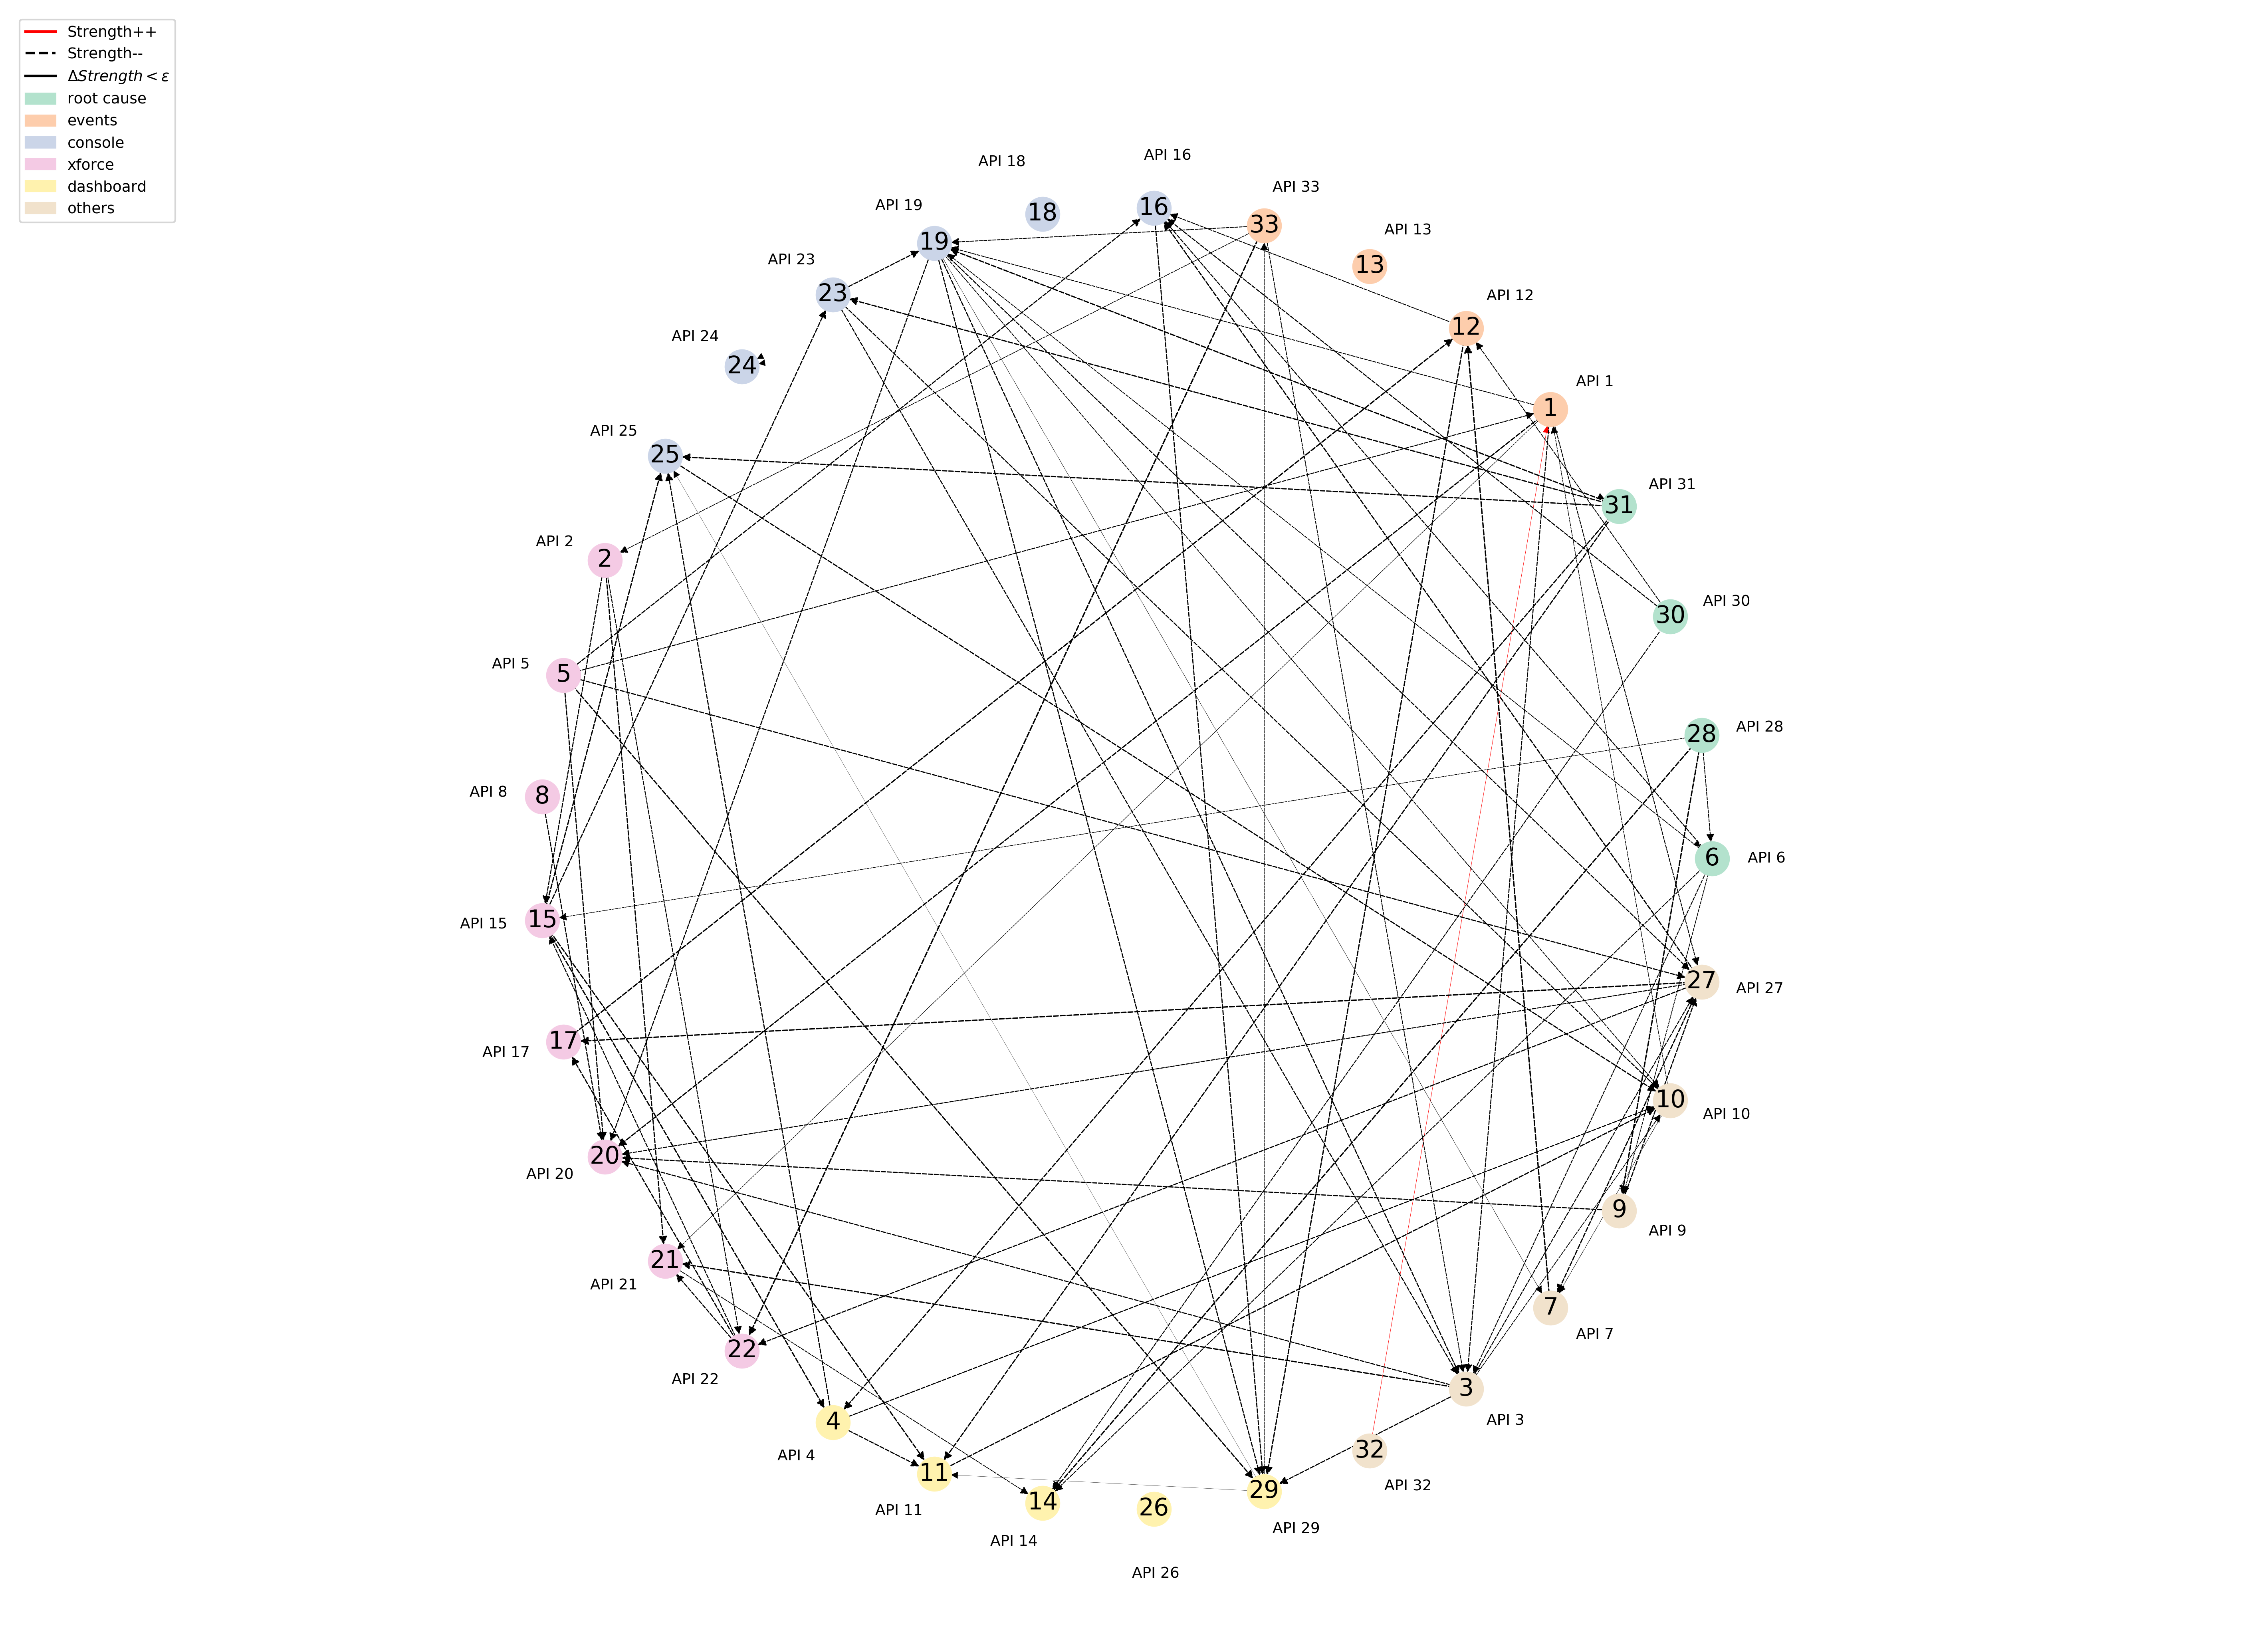

In [56]:
min_weight = 0.1
g1 = get_graph_timestamp(0, min_weight=min_weight)
g2 = get_graph_timestamp(300, min_weight=min_weight)
g3 = get_graph_timestamp(540, min_weight=min_weight)
# g_diff = graph_diff(g2, g1)
g_diff = graph_diff(g3, g2)

fig = plt.figure(figsize=[24, 18], dpi=300)
fig.subplots_adjust(wspace=0.0)
ax = fig.subplots(1, 1)
draw_graph_diff(g_diff, width_multi=1, ax=ax, plot_thres=0.2)
os.makedirs(os.path.join(dir_output, 'graph-dynamics'), exist_ok=True)
# plt.savefig(os.path.join(dir_output, 'graph-dynamics','full-g-diff-300-0.svg'), dpi=fig.dpi, bbox_inches='tight')
# plt.savefig(os.path.join(dir_output, 'graph-dynamics','full-g-diff-540-300.svg'), dpi=fig.dpi, bbox_inches='tight')

## Data sensitivity

### Anomaly interval size (Figure 8)
Influence of pre-interval and post-interval length.

In [3]:
def extract_runtime(runtime_results, key, fix_key):
    result_key_dict = {}
    for result in runtime_results:
        key_len = result[key]
        runtime = result['runtime']
        if result[fix_key] == 0:
            if key_len in result_key_dict:
                result_key_dict[key_len]['runtime'].append(runtime)
            else:
                result_key_dict[key_len] = {}
                result_key_dict[key_len]['runtime'] = [runtime]
    runtime_dict = {}
    for key, d in result_key_dict.items():
        runtime_dict[key] = np.mean(d['runtime'])
    return runtime_dict


def extract_max_prk_acc(results_list, key):
    result_key_dict = {}
    for result in results_list:
        key_len = result[key]
        prks = result['prks']
        acc = result['acc']
        if key_len in result_key_dict:
            result_key_dict[key_len]['prks'].append(prks)
            result_key_dict[key_len]['acc'].append(acc)
        else:
            result_key_dict[key_len] = {}
            result_key_dict[key_len]['prks'] = [prks]
            result_key_dict[key_len]['acc'] = [acc]    
    acc_dict = {}
    for key, d in result_key_dict.items():
        acc_dict[key] = (
            np.max([np.mean(prks) for prks in d['prks']]),
            np.max(d['acc'])
        )
    return acc_dict
    
    
with open('exp_records/granger_extend_parameter_tune_ibm_707.pkl', 'rb') as f:
    results = pickle.load(f)
with open('exp_records/granger_extend_runtime_ibm_708.pkl', 'rb') as f:
    runtime_results = pickle.load(f)
with open('exp_records/granger_extend_parameter_tune_ibm_708.pkl', 'rb') as f:
    aft_acc_dict = extract_max_prk_acc(pickle.load(f), 'aft')
    
bef_acc_dict = extract_max_prk_acc(results, 'bef')
bef_time_dict = extract_runtime(runtime_results, 'bef', 'aft')
aft_time_dict = extract_runtime(runtime_results, 'aft', 'bef')
bef_acc_dict, bef_time_dict, aft_time_dict

({20: (0.0, 0.0),
  40: (0.0, 0.0),
  60: (0.0, 0.0),
  80: (0.0, 0.0),
  100: (0.0, 0.0),
  120: (0.4666666666666666, 0.25),
  140: (0.0, 0.0),
  160: (0.4666666666666666, 0.5),
  180: (0.7333333333333333, 0.5),
  200: (0.0, 0.0),
  220: (0.7333333333333333, 0.5),
  240: (0.7833333333333333, 0.9545454545454546),
  260: (0.7333333333333333, 0.7196969696969697),
  280: (0.8333333333333333, 0.75)},
 {20: 2.851777267456055,
  40: 2.9406564235687256,
  60: 4.708706569671631,
  80: 4.424830055236816,
  100: 2.9658979892730715,
  120: 8.111386966705322,
  140: 8.093755340576172,
  160: 13.706003999710083,
  180: 13.473936462402344,
  200: 4.314783048629761,
  220: 20.561266374588012,
  240: 22.193760871887207,
  260: 34.9655858039856,
  280: 30.22495307922363},
 {20: 2.7992980003356935,
  40: 2.8590631008148195,
  60: 4.498568296432495,
  80: 4.5115314483642575,
  100: 2.895434617996216,
  120: 7.712109375,
  140: 8.10218653678894,
  160: 14.528023672103881,
  180: 14.1005943775177,
  200: 8

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


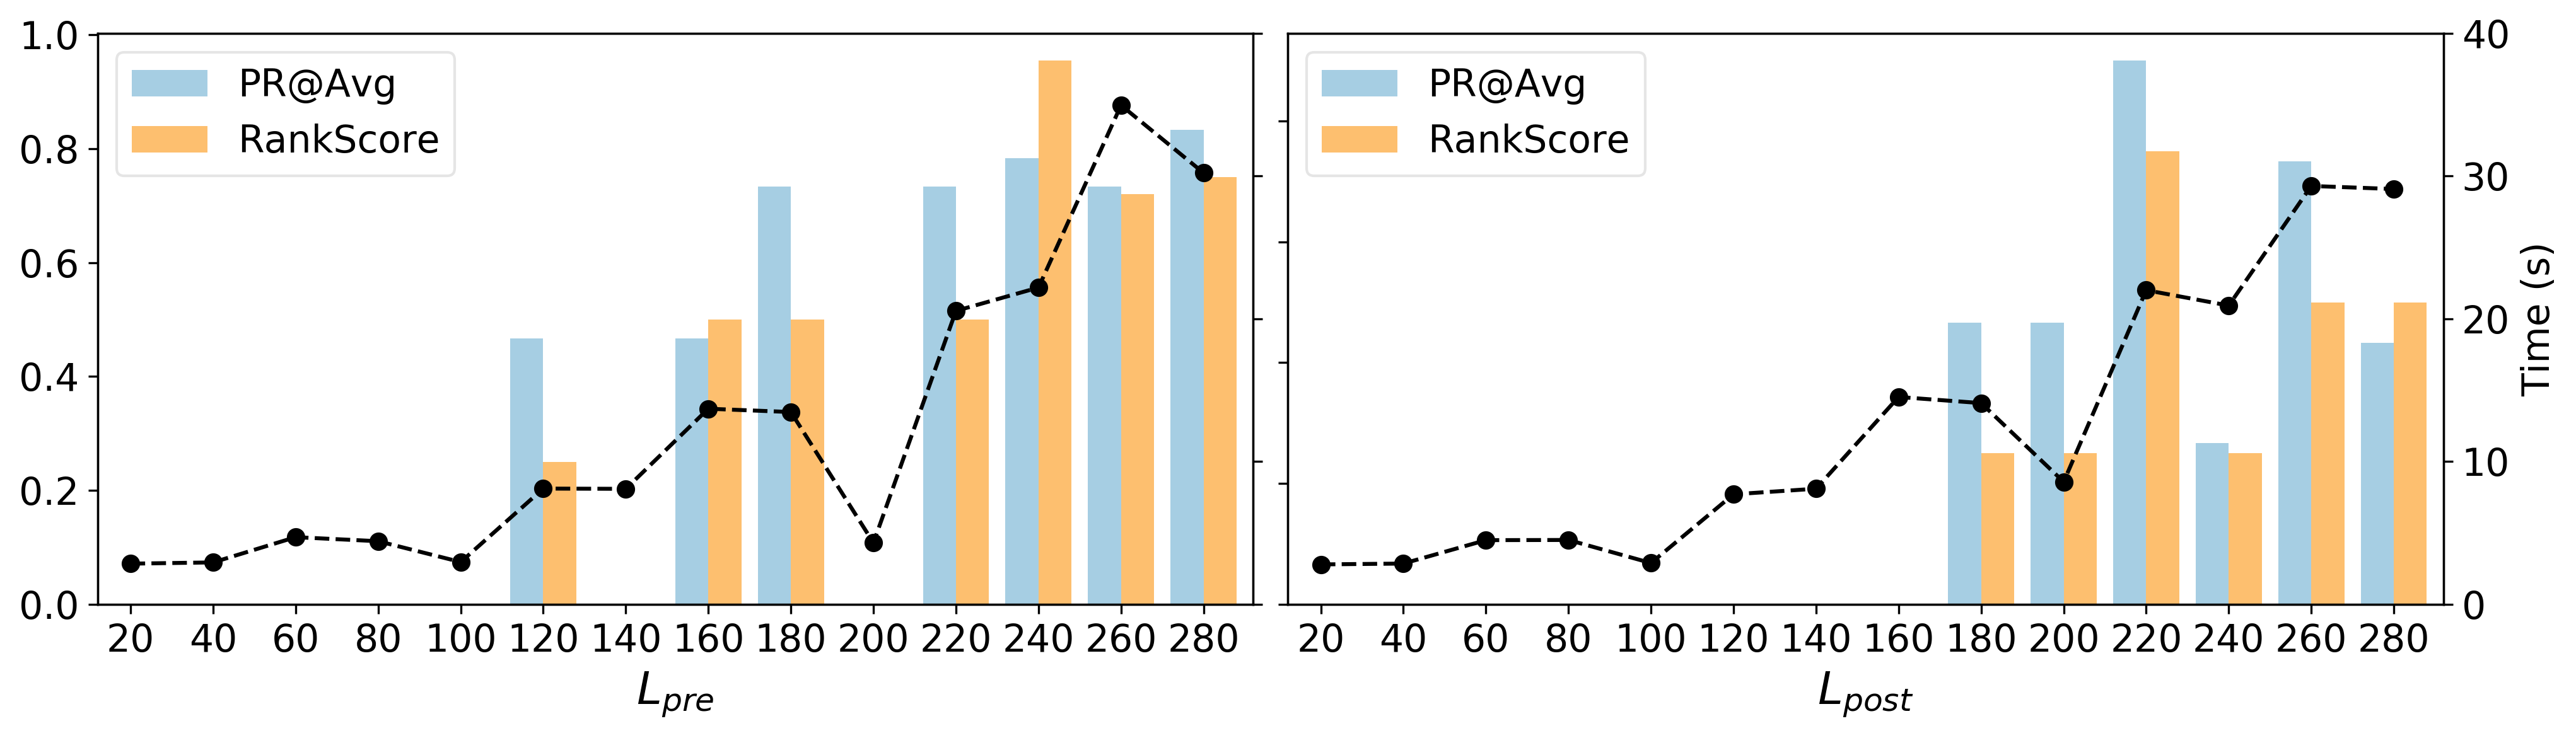

In [58]:
def get_heights_by_data_len(acc_dict):
    heights_array = [[] for i in range(2)]
    xlabels = []
    for bef_len, prks_acc in acc_dict.items():
        xlabels.append(bef_len)
        heights_array[0].append(prks_acc[0])
        heights_array[1].append(prks_acc[1])
    xlabels = np.array(xlabels)
    return xlabels, heights_array

def draw_runtime(runtime_array, ax, bar_step, num_bar):
    fontsize='x-large'
    width = (bar_step*0.8)/num_bar
    ax.plot(np.arange(len(runtime_array))+0.5*width*num_bar, runtime_array, linestyle='--', 
            marker='o', color='k')
    ax.set_ylabel('Time (s)', fontsize=fontsize)

# 1 column 2 rows layout
# fig = plt.figure(figsize=[10, 6], dpi=300)
# axs = fig.subplots(2, 1, sharex=True)

# 2 columns 1 row layout
fig = plt.figure(figsize=[16, 4], dpi=300)
axs = fig.subplots(1, 2)
fig.subplots_adjust(wspace=0.03,hspace=0.0)

fig.subplots_adjust(hspace=0.2)
xlabels, heights_array = get_heights_by_data_len(bef_acc_dict)
draw_stacked_bar(xlabels, heights_array, ax=axs[0], num_xlabels=None, draw_bar_height=False, xlabel='$L_{pre}$',
                 xlabel_format='{:d}')
xlabels, heights_array = get_heights_by_data_len(aft_acc_dict)
draw_stacked_bar(xlabels, heights_array, ax=axs[1], num_xlabels=None, draw_bar_height=False, xlabel='$L_{post}$',
                 xlabel_format='{:d}')

min_time = 0
max_time = 40
fontsize='x-large'
ax = axs[0].twinx()
draw_runtime([t for t in bef_time_dict.values()], ax, 1.0, 2)
ax.set_ylim(min_time, max_time)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_ylabel('')
# ax.set_yticks([])
ax.set_yticklabels([])

axs[1].set_yticklabels([])
ax = axs[1].twinx()
ax.set_ylim(min_time, max_time)
ax.tick_params(axis='y', labelsize=fontsize)
draw_runtime([t for t in aft_time_dict.values()], ax, 1.0, 2)
plt.savefig(os.path.join(dir_output, 'data-sensitivity', 'pre-post-len-effect-2cols.eps'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(dir_output, 'data-sensitivity', 'pre-post-len-effect.eps'), bbox_inches='tight')

### Aggregation size (Figure 11)
After we rerun the experiments of aggregation size, new results are much better.
> Some results are from the manual run of the specific method. 

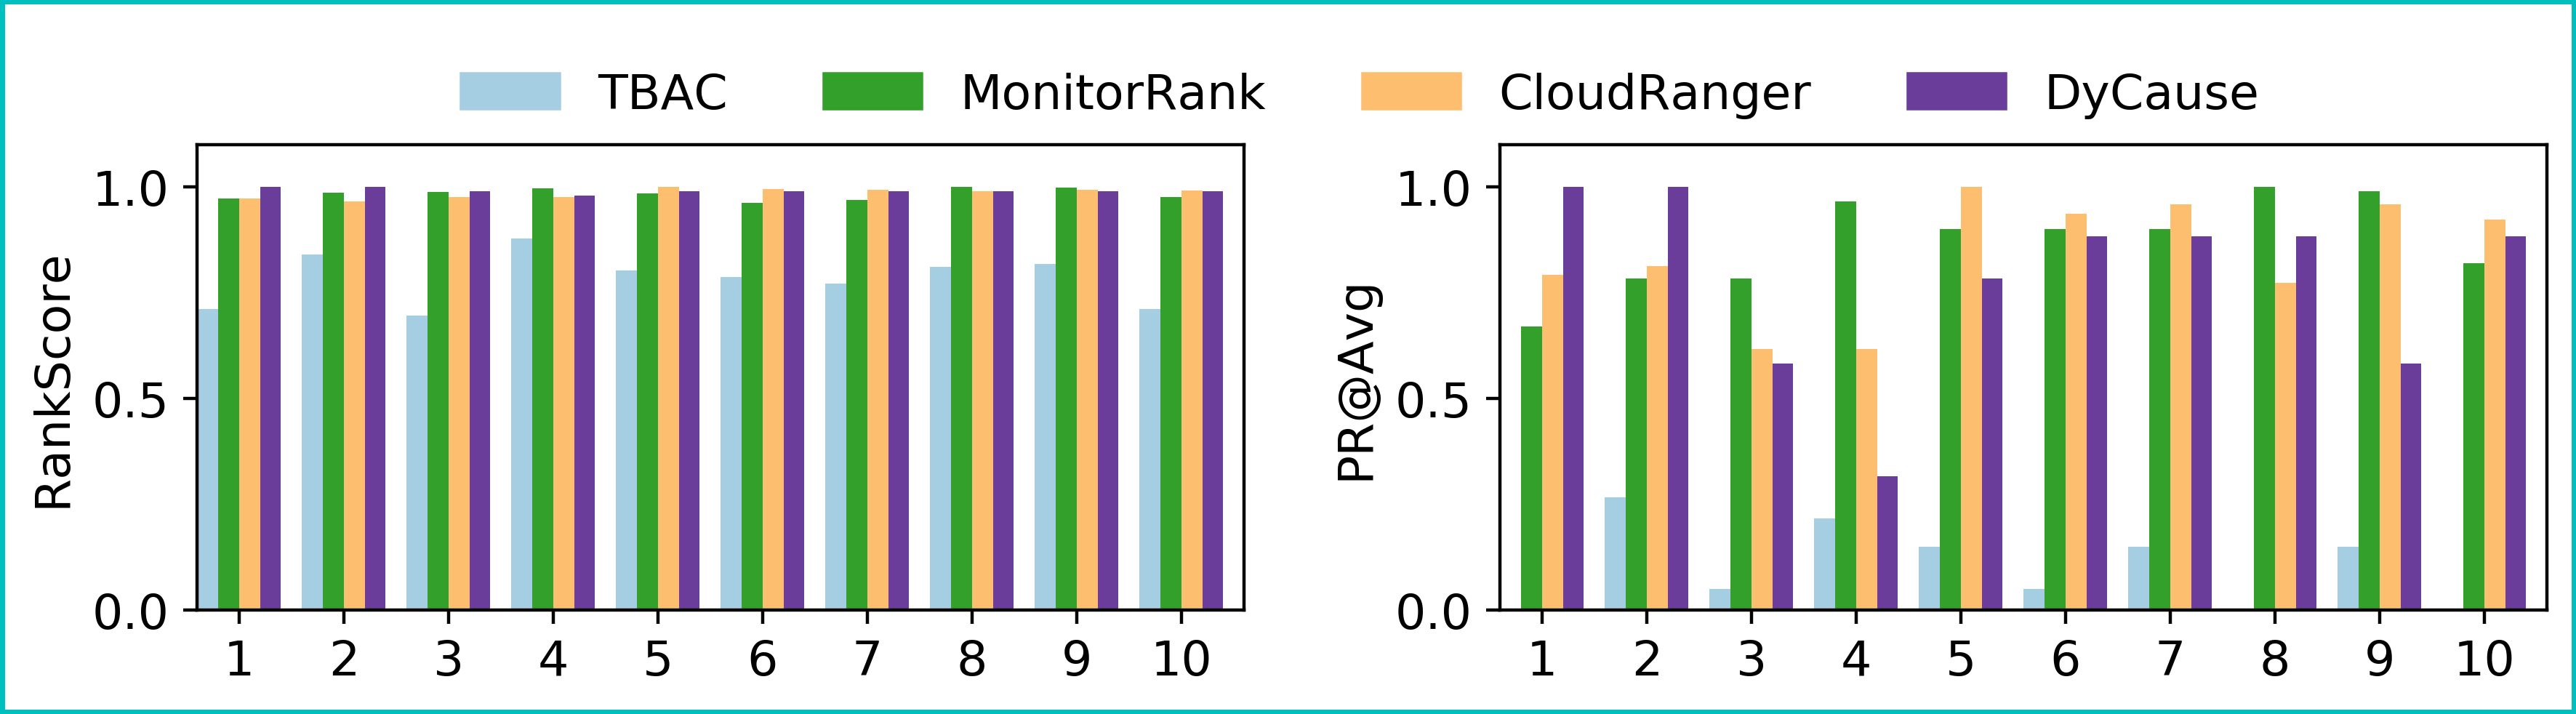

In [59]:
# fig = plt.figure(figsize=[5, 4], dpi=400, edgecolor='c', linewidth=2)
fig = plt.figure(figsize=[8, 2], dpi=400, edgecolor='c', linewidth=2)
# axs = fig.subplots(1, 2, sharex=True)
fig.subplots_adjust(wspace=0.0,hspace=0.0)
fontsize='large'
xlabels = [str(i) for i in range(1,11)]
method_labels = ['TBAC', 'MonitorRank', 'CloudRanger', 'DyCause']
cmap=plt.get_cmap('Paired')
heights_array_acc = []
heights_array_prkavg = []

# TBAC
heights_array_acc.append(
    [0.712121212, 0.840909091, 0.696969697, 0.878787879, 0.803030303, 0.787878788, 0.772727273, 0.810606061, 0.818181818, 0.712121212])
heights_array_prkavg.append([
    0,0.266666667,0.05,0.216666667,0.15,0.05,0.15,0,0.15,0
])

# MonitorRank (fix pc_agg at 20, pc_alpha at 0.1)
heights_array_acc.append([
    0.972727273,0.986363636,0.987878788,0.996969697,0.984848485,0.962121212,0.96969697,1,0.998484848,0.977272727
])
heights_array_prkavg.append([
    0.67,0.783333333,0.783333333,0.966666667,0.9,0.9,0.9,1,0.99,0.82
])

# CloudRanger (fix pc_agg at 20, pc_alpha at 0.1)
heights_array_acc.append([
    0.972727273,0.966666667,0.977272727,0.977272727,1,0.995454545,0.993939394,0.990909091,0.993939394,0.992424242
])
heights_array_prkavg.append([
    0.793333333,0.813333333,0.616666667,0.616666667,1,0.936666667,0.96,0.773333333,0.96,0.923333333
])

# MicroCause

# Results on manual experiments
# heights_array_acc.append([
#     0.926470588, 0.9545454545454546, 0.9545454545454546, 0.9696969696969697, 0.9621212121212122, 
#     0.9848484848484849, 0.9621212121212122, 0.9924242424242424, 1.0, 0.9696969696969697
# ])
# heights_array_prkavg.append([
#     0.1, 0.9, 0.4833333333333333, 0.41666666666666663, 0.4833333333333333, 
#     0.7333333333333333, 0.4833333333333333, 0.95, 1.0, 0.6833333333333333
# ])

# #  Results of second runs
# heights_array_acc.append([
#     0.96969697,0.962121212,0.96969697,0.96969697,0.954545455,0.954545455,0.977272727,0.977272727,0.977272727,0.977272727
# ])
# heights_array_prkavg.append([
#     0.316666667,0.266666667,0.483333333,0.483333333,0.316666667,0.516666667,0.316666667,0.783333333,0.9,0.416666667
# ])

# Granger extend
heights_array_acc.append([1.00, 1.00, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99])
heights_array_prkavg.append([
    1.0,1.0,0.5833333333333333,0.31666666666666665,0.7833333333333333,
    0.8833333333333332,0.8833333333333332,0.8833333333333332,0.5833333333333333,0.8833333333333332,
])

legend_bottom = 0.9
ax0 = fig.add_axes([0.0, legend_bottom, 1.0, 1.0-legend_bottom])
cmap=plt.get_cmap('Paired')
from matplotlib.patches import Rectangle
lines = [
    Rectangle((0,0),0.1,0.1,
        color=cmap(i/len(heights_array_acc)), label=label)
    for i, label in enumerate(method_labels)]
ax0.legend(handles=lines, loc='upper center', fontsize=fontsize, framealpha=0.5, ncol=4, frameon=False)
ax0.set_axis_off()
ax0.set_frame_on(False)

width = 0.45
height = legend_bottom-0.1
center=0.56
ax1 = fig.add_axes([0, 0, width, height])
ax2 = fig.add_axes([center, 0, width, height])

ax1.set_ylabel('RankScore', fontsize=fontsize)
ax1.set_ylim(0, 1.0+0.1)

# Plot the RankScore metric
draw_stacked_bar(xlabels, heights_array_acc, savename=False, ax=ax1, xlabel_format='{}', num_xlabels=None, 
                 draw_bar_height=False, xlabel=None, bar_labels=None, bar_step=1.0, fontsize=fontsize)
# ax1.set_xticks([])


ax2.set_ylabel('PR@Avg', fontsize=fontsize)
ax2.set_ylim(0, 1.0+0.1)
# # Plot PR@Avg
draw_stacked_bar(xlabels, heights_array_prkavg, savename=False, ax=ax2, xlabel_format='{}', num_xlabels=None, 
                 draw_bar_height=False, xlabel=None, bar_labels=None, bar_step=1.0, fontsize=fontsize)

# linestyle_tuple = [
#      ('loosely dotted',        (0, (1, 10))),
#      ('dotted',                (0, (1, 1))),
#      ('densely dotted',        (0, (1, 1))),

#      ('loosely dashed',        (0, (5, 10))),
#      ('dashed',                (0, (5, 5))),
#      ('densely dashed',        (0, (5, 1))),

#      ('loosely dashdotted',    (0, (3, 10, 1, 10))),
#      ('dashdotted',            (0, (3, 5, 1, 5))),
#      ('densely dashdotted',    (0, (3, 1, 1, 1))),

#      ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
#      ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
#      ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

# markers = [
#     '+',
#     'x',
#     "^",
#     "v"
# ]
# for i, method in enumerate(method_labels):
#     ax1.plot(range(1,11), heights_array_acc[i], '-', color=cmap(i/len(method_labels)), linestyle=(0, (5, 5)), marker=markers[i])
# for i, method in enumerate(method_labels):
#     ax1.plot(range(1,11), heights_array_prkavg[i], '-', color=cmap(i/len(method_labels)), linestyle=(0, (3, 5, 1, 5)), marker=markers[i])

# ax1.set_xticks(range(1,11))
# ax1.set_xticklabels(xlabels)
# ax1.tick_params(labelsize=fontsize, axis='both')

# from matplotlib.lines import Line2D
# lines = [
#     Line2D([], [], linestyle=(0, (5, 5)), marker='x', label='RankScore', color='k'),
#     Line2D([], [], linestyle=(0, (3, 5, 1, 5)), marker='+', label='Prk@Avg', color='k')
# ]
# ax1.legend(handles=lines, loc='upper left', fontsize=fontsize, framealpha=0.5, ncol=1)


filename = 'Fig-10-aggregation-2cols'
plt.savefig(os.path.join(dir_output, 'data-sensitivity',f'{filename}.eps'), dpi=fig.dpi, bbox_inches='tight')
plt.savefig(os.path.join(dir_output, 'data-sensitivity',f'{filename}.png'), dpi=fig.dpi, bbox_inches='tight')
# plt.savefig(os.path.join(dir_output, 'data-sensitivity','aggregation-new.eps'), bbox_inches='tight')
plt.show()

### Input window of different lengths centered at same abnormal period (Figure 9)
With the period in $[4653 \to 4853]$ as center period, we construct input data of lengths 200, 1200, 2400, 3600, 4800, 7200 and then test methods MonitorRank, CloudRanger and Granger extend.

* ```test_all_perf_ibm_customwindow_0818_2.pkl``` This pkl file contains the experiment records of MonitorRank, CloudRanger, Granger extend for data in [4653, len 200], [4153, len 1200], [3553, len 2400]. Also contains the PC algorithm time cost.
* ```test_all_perf_ibm_customwindow_0818.pkl``` This pkl file contains the experiment records of MonitorRank, CloudRanger, Granger extend for data in [4653, len 200, 1200, 2400], [4153, len 200, 1200, 2400], [3553, len 200, 1200, 2400]. Also contains the PC algorithm time cost.
* ```test_all_perf_ibm_overlappedwindows_len3600_len4800.pkl``` This pkl file contains the experiment records of Granger extend on overlapped input window data of length 3600, 4800.

> We also manually run some methods to get their performance that are not included in the pickle files.

In [5]:
def extract_pc_time(result_dict):
    """Extract time cost for PC algorithm.
    Params:
        result_dict: the dict storing the result lists for each method (including PC algorithm)
    Returns:
        pc_time_dict: the dict containing time cost of PC algorithm. 
            Dict {window_start --> Dict {window_len --> Dict {Aggregate --> Dict {Alpha --> time}}}}
    """
    pc_time_dict = {}
    for i in result_dict['pc algorithm']:
        window_start = i['window_start']
        window_len = i['window_len']
        pc_aggregate = i['pc_aggregate']
        pc_alpha = i['pc_alpha']
        if window_start not in pc_time_dict:
            pc_time_dict[window_start] = {}
        if window_len not in pc_time_dict[window_start]:
            pc_time_dict[window_start][window_len] = {}
        if pc_aggregate not in pc_time_dict[window_start][window_len]:
            pc_time_dict[window_start][window_len][pc_aggregate] = {}
        if pc_alpha not in pc_time_dict[window_start][window_len][pc_aggregate]:
            pc_time_dict[window_start][window_len][pc_aggregate][pc_alpha] = None
        pc_time_dict[window_start][window_len][pc_aggregate][pc_alpha] = i['pc_time']
    return pc_time_dict


def extract_acc(result_dict, method_name, raw=False, pc_time_dict=None):
    """Extract the maximum Acc and corresponding time cost for method for each window.
    
    Params:
        result_dict: the dict storing the result lists for each method (including PC algorithm)
        method_name: method name to extract acc result
        raw: whether return raw acc list, default False. Return mean and std of acc.
        pc_time_dict: the external dict of PC algorithim time cost. PC time cost is only added when > 0.
            If None, will be calculated here. 
            If False, will disable adding PC time cost.
    
    Returns:
        acc_list: the maximum Acc of this method.
        time_list: the corresponding time cost that achieves maximum Acc.
    """
    # Get PC algorithm time cost if not provided and not granger extend method
    if pc_time_dict is None and method_name != 'grangerextend':
        pc_time_dict = extract_pc_time(result_dict)
    acc_dict = {}
    runtime_dict = {}
    def allocate_2keys(d, k1, k2, v):
        if k1 not in d:
            d[k1] = {}
        if k2 not in d[k1]:
            d[k1][k2] = []
        d[k1][k2].append(v)
    for i in result_dict[method_name]:
        window_start = i['window_start']
        window_len = i['window_len']
        # Append Acc to acc_dict
        allocate_2keys(acc_dict, window_start, window_len, i['acc'])
        # Append time cost to runtime_dict
        #   basic method time
        runtime = i['time']
        #   Get PC algorithm parameters and add to basic method time. 
        #   Skip addition if pc_time < 0 (negative pc_time means no valid time record).
        if method_name != 'grangerextend' and pc_time_dict is not False:
            pc_aggregate = i['pc_aggregate']
            pc_alpha = i['pc_alpha']
            pc_time = pc_time_dict[window_start][window_len][pc_aggregate][pc_alpha]
            if pc_time > 0:
                runtime += pc_time
        allocate_2keys(runtime_dict, window_start, window_len, runtime)
    
    acc_list = []
    time_list = []
    # Get sorted keys 1: ascending window_start
    key1_inds = sorted(list(acc_dict.keys()))
    for k1 in key1_inds:
        # Get sorted keys 2: ascending window_len
        key2_inds = sorted(list(acc_dict[k1].keys()))
        for k2 in key2_inds:
            acc_v = np.array(acc_dict[k1][k2])
            time_v = np.array(runtime_dict[k1][k2])
            # Get indices that sort Acc descending
            inds = np.argsort(acc_v)[::-1]
            if not raw:
                selected_acc = np.take_along_axis(acc_v, inds[:5], axis=0)
                selected_time = np.take_along_axis(time_v, inds[:5], axis=0)
                acc_list.append((np.mean(selected_acc), np.std(selected_acc), np.max(selected_acc)))
                time_list.append((np.mean(selected_time), np.std(selected_time), np.max(selected_time)))
            else:
                acc_list.append(acc_v)
                time_list.append(time_v)
    return acc_list, time_list

def extract_labels(result_dict):
    """Get the window_start and window_len labels of the input window experiment
    """
    start_list = set()
    len_list = set()
    for v in result_dict.values():
        for i in v:
            start_list.add(i['window_start'])
            len_list.add(i['window_len'])
        break
    return sorted(list(start_list)), sorted(list(len_list))

def extract_best_params(result_dict, method_name):
    """Get the best parameters for given method in result_dict.
    
    Params:
        result_dict: the dict storing the result lists for each method (including PC algorithm)
        method_name: method name to extract best parameters
    
    Returns:
        param_list: a list of parameters that achieves the maximum Acc at each window_start, window_len
    """
    acc_dict = {}
    param_dict = {}
    def allocate_2keys(d, k1, k2, v):
        if k1 not in d:
            d[k1] = {}
        if k2 not in d[k1]:
            d[k1][k2] = []
        d[k1][k2].append(v)
    for i in result_dict[method_name]:
        window_start = i['window_start']
        window_len = i['window_len']
        # Append Acc to acc_dict
        allocate_2keys(acc_dict, window_start, window_len, i['acc'])
        allocate_2keys(param_dict, window_start, window_len, i)
    param_list = []
    # Get sorted keys 1: ascending window_start
    key1_inds = sorted(list(acc_dict.keys()))
    for k1 in key1_inds:
        # Get sorted keys 2: ascending window_len
        key2_inds = sorted(list(acc_dict[k1].keys()))
        for k2 in key2_inds:
            acc_v = acc_dict[k1][k2]
            param_list.append(param_dict[k1][k2][np.argmax(acc_v)])
    return param_list



# pc_time_dict = extract_pc_time(result_dict)
# method_name = ['tbac', 'netmedic', 'monitorrank', 'cloudranger', 'grangerextend'][4]
# window_start = 0

# pc_time = np.array([i['pc_time'] for i in result_dict['pc algorithm'] if i['window_start'] == window_start])
# pc_time

#### Load the accuracy and runtime results

In [7]:
with open('exp_records/test_all_perf_ibm_customwindow_0818_2.pkl', 'rb') as f:
    pc_time_len200 = extract_pc_time(pickle.load(f))

with open('exp_records/test_all_perf_ibm_customwindow_0818.pkl', 'rb') as f:
    result_dict = pickle.load(f)
# The following filters out invalid experiment records for test_all_perf_ibm_customwindow_0818.pkl
for method_name in ['monitorrank', 'cloudranger', 'grangerextend', 'pc algorithm']:
    filtered_list = []
    for i in result_dict[method_name]:
        if i['window_start'] == 4653 and i['window_len'] == 200:
            filtered_list.append(i)
        if i['window_start'] == 4153 and i['window_len'] == 1200:
            filtered_list.append(i)
        if i['window_start'] == 3553 and i['window_len'] == 2400:
            filtered_list.append(i)
    result_dict[method_name] = filtered_list    
    
with open('exp_records/test_all_perf_ibm_overlappedwindows_len3600_len4800.pkl', 'rb') as f:
    result_dict_len3648 = pickle.load(f)
# with open('test_grangerextend_perf_ibm_overlappedwindows_len1200_0819.pkl', 'rb') as f:
#     granger_result_dict = pickle.load(f)

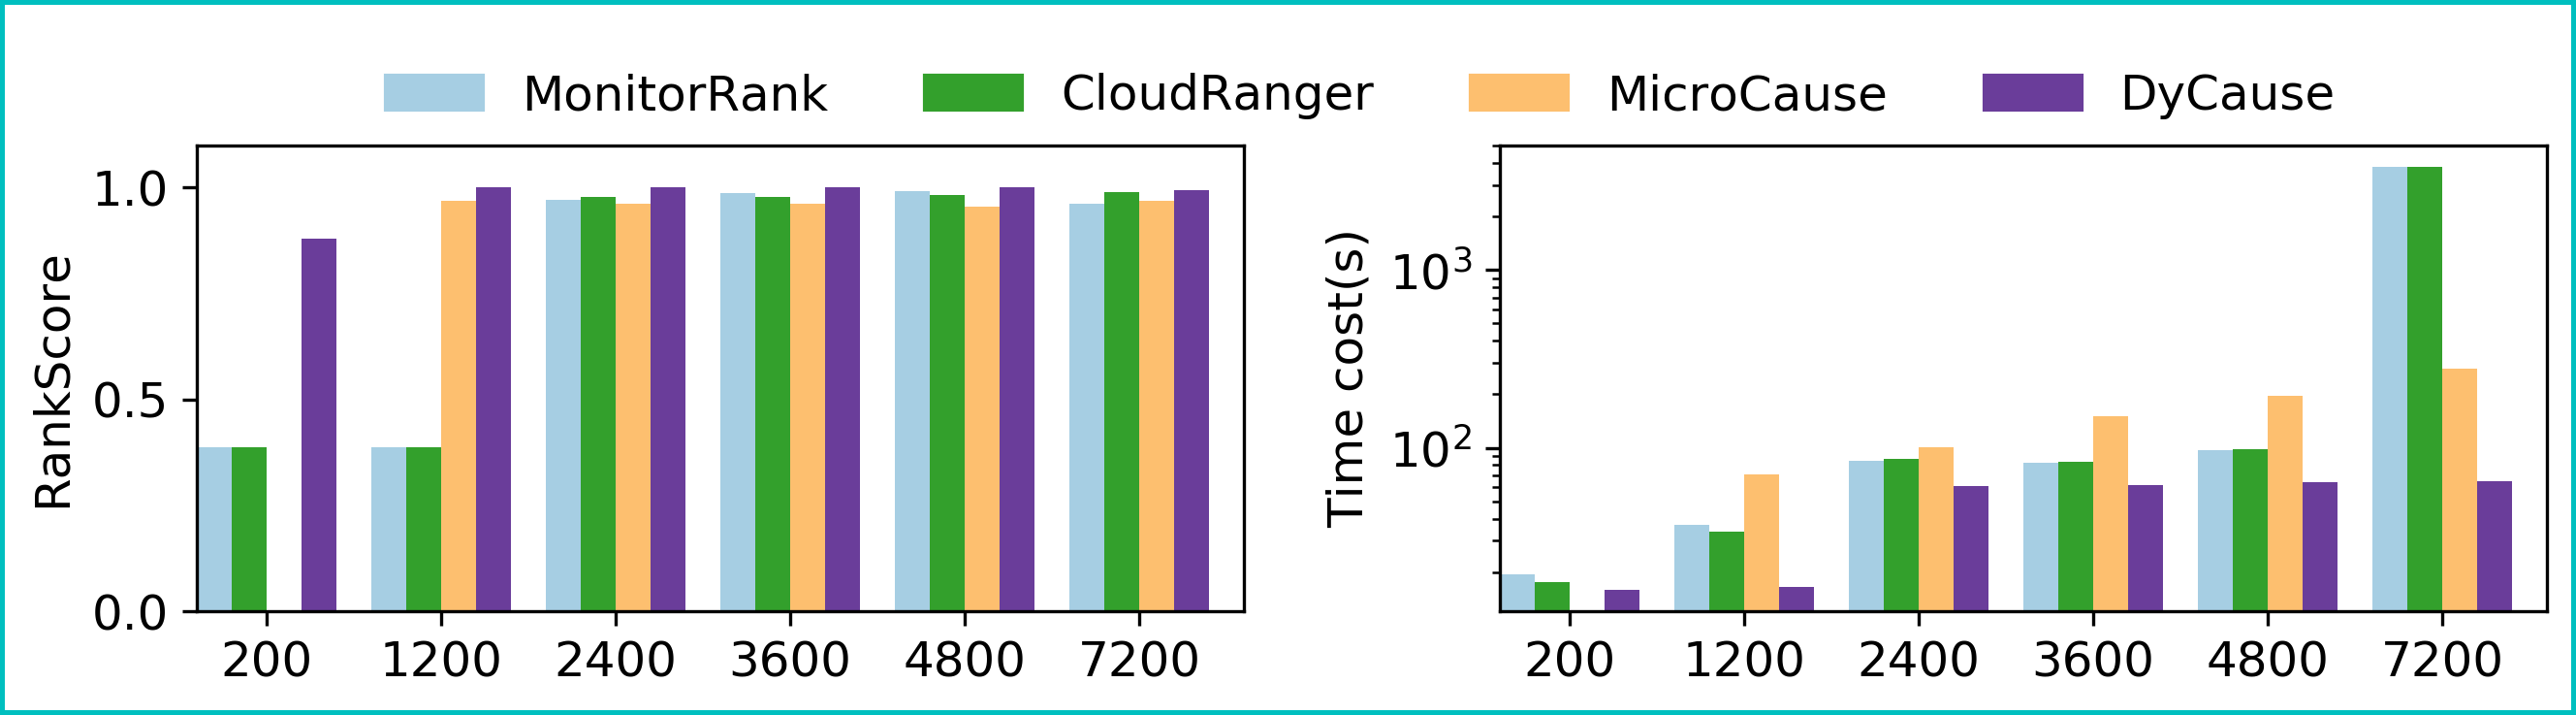

In [10]:
fig = plt.figure(figsize=[8, 2], dpi=300, edgecolor='c', linewidth=2)
# fig = plt.figure(figsize=[5, 4], dpi=400)

fontsize='large'
pc_time_dict = extract_pc_time(result_dict)
# xlabels = extract_labels(result_dict)
xlabels = ['200', '1200', '2400', '3600', '4800', '7200']
method_labels = ['MonitorRank', 'CloudRanger', 'MicroCause', 'DyCause']
cmap=plt.get_cmap('Paired')
heights_array_acc = []
heights_array_time = []
for i, method_name in enumerate(['monitorrank', 'cloudranger', 'grangerextend']):
    # Extract maximum Acc and corresponding time cost
    acc_list, time_list = extract_acc(result_dict, method_name, pc_time_dict=pc_time_dict)
    heights_array_acc.append([_[2] for _ in acc_list][::-1])
    heights_array_time.append([_[2] for _ in time_list][::-1])

# MonitorRank (fix pc_agg at 20, pc_alpha at 0.1)
#   at 200, 1200, 2400
heights_array_acc[0][0] = 0.38636363636363635
heights_array_time[0][0] = 16.07940125465393 + 3.253232955932617
heights_array_acc[0][1] = 0.38636363636363635
heights_array_time[0][1] = 33.415634632110596 + 3.2661378383636475
heights_array_acc[0][2] = 0.9712121212121213
heights_array_time[0][2] = 81.64550876617432 + 3.4155
#   at 3600, 4800, 7200
heights_array_acc[0].extend([0.9878787878787879, 0.9924242424242424, 0.9621212121212122])
heights_array_time[0].extend([79.5601851940155+3.3288676738739014, 
                              93.94623732566833+3.5280, 
                              3809.8500475883484+3.5722])
# heights_array_time[0][2] = 45.4105589389801 + 3.0567641258239746

# CloudRanger (fix pc_agg at 20, pc_alpha at 0.1)
#   at 200, 1200, 2400
heights_array_acc[1][2] = 0.9772727272727273
heights_array_time[1][0:3] = [14.034700155258179+3.600538492202759,
                             30.243446350097656+3.537264108657837,
                             81.64550876617432+4.7629]
#   at 3600, 4800, 7200
heights_array_acc[1].extend([0.9772727272727273, 0.9818, 0.9893939393939393])
heights_array_time[1].extend([79.5601851940155+3.5183629989624023, 
                              93.94623732566833+4.5325, 
                              3809.8500475883484+4.5059])

# Granger extend
#   at 200, 1200, 2400
heights_array_acc[2][1] = 1.0
heights_array_time[2][0] = 15.906105756759644
heights_array_time[2][1] = 16.54626989364624
heights_array_time[2][2] = 61.0653
#   at 3600, 4800, 7200
heights_array_acc[2].extend([1.0, 1.0, 0.9950])    
heights_array_time[2].extend([61.5064, 63.8628, 65.3423])

# MicroCause
#   move DyCause to last one
heights_array_acc.append(heights_array_acc[2])
heights_array_time.append(heights_array_time[2])
#   add MicroCause to [2]
#   200, 1200, 2400, 3600, 4800, 7200
heights_array_acc[2] = [0, 0.9697, 0.9621, 0.9621, 0.9545, 0.9697]
heights_array_time[2] = [0, 71.07999709597789, 100.55095747625455, 150.88935561478138, 196.16880212305114, 277.4339311630465]
    
# Layout 1: simple two columns layout
# axs = fig.subplots(1, 2, sharex=True)
# fig.subplots_adjust(wspace=0.15)
    
# Layout 2: draw legend in top axes  
legend_bottom = 0.90
ax0 = fig.add_axes([0.0, legend_bottom, 1.0, 1.0-legend_bottom])
cmap=plt.get_cmap('Paired')
from matplotlib.patches import Rectangle
lines = [
    Rectangle((0,0),0.1,0.1,
        color=cmap(i/len(heights_array_acc)), label=label)
    for i, label in enumerate(method_labels)]
ax0.legend(handles=lines, loc='upper center', fontsize=fontsize, framealpha=0.5, ncol=4, frameon=False)
ax0.set_axis_off()
ax0.set_frame_on(False)

# Layout 2-1: draw the two bar plots on two columns
width = 0.45
height = 0.45
center=0.56
ax1 = fig.add_axes([0, 0, width, legend_bottom-0.1])
ax1.set_ylim(0, 1.0+0.1)
ax2 = fig.add_axes([center, 0.0, width, legend_bottom-0.1])
axs = [ax1, ax2]

# Layout 2-2: draw the two bar plots on two rows
# width = 1.0
# height = 0.45
# ax1 = fig.add_axes([0.0, height-0.02, 1.0, height-0.07])
# ax1.set_ylim(0, 1.0+0.1)
# ax2 = fig.add_axes([0.0, 0.0+0.02, 1.0, height-0.07])
# axs = [ax1, ax2]


# Plot the Acc metric
draw_stacked_bar(xlabels, heights_array_acc, savename=False, ax=axs[0], xlabel_format='{}', num_xlabels=None, 
                 draw_bar_height=False, xlabel=None, bar_labels=None, bar_step=1.0, fontsize=fontsize)
# Clear the top plot's xticks if draw vertically
# axs[0].set_xticks([])

# Plot Time cost
draw_stacked_bar(xlabels, heights_array_time, savename=False, ax=axs[1], xlabel_format='{}', num_xlabels=None, 
                 draw_bar_height=False, xlabel=None, bar_labels=None, bar_step=1.0, fontsize=fontsize)

# set properties of top axes, Acc plot
# axs[0].set_xticks(xlabels)
axs[0].set_ylabel('RankScore', fontsize=fontsize)
# axs[0].legend(loc='upper left', fontsize=fontsize)

# set properties of bottom axes, Time cost plot
# axs[1].set_xticks(xlabels)
# axs[1].set_xticklabels(["[{}-{})".format(_, _+window_len) for _ in xlabels])
# axs[1].set_xticklabels()
axs[1].set_ylabel('Time cost(s)', fontsize=fontsize)
axs[1].set_yscale('log')
# axs[1].legend(loc='upper left', fontsize=fontsize)
filename = 'Fig-9-window-length-2cols'
# plt.savefig(os.path.join(dir_output, 'data-sensitivity',filename+'.eps'), dpi=fig.dpi, bbox_inches='tight')
# plt.savefig(os.path.join(dir_output, 'data-sensitivity',filename+'.png'), dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [81]:
import pandas as pd

In [86]:
df = pd.DataFrame({name: heights_array_acc[i]for i, name in enumerate(method_labels)})
df['Len'] = [200, 1200, 2400, 3600, 4800, 7200]
df = df.set_index('Len')
df.to_csv(os.path.join(dir_output, 'data-sensitivity','window-length-acc.csv'))
df

,MonitorRank,CloudRanger,MicroCause,DyCause
Len,,,,
200,0.386364,0.386364,0.0000,0.878788
1200,0.386364,0.386364,0.9697,1.000000
2400,0.971212,0.977273,0.9621,1.000000
3600,0.987879,0.977273,0.9621,1.000000
4800,0.992424,0.981800,0.9545,1.000000
7200,0.962121,0.989394,0.9697,0.995000


In [87]:
df = pd.DataFrame({name: heights_array_time[i]for i, name in enumerate(method_labels)})
df['Len'] = [200, 1200, 2400, 3600, 4800, 7200]
df = df.set_index('Len')
df.to_csv(os.path.join(dir_output, 'data-sensitivity','window-length-time.csv'))
df

,MonitorRank,CloudRanger,MicroCause,DyCause
Len,,,,
200,19.332634,17.635239,0.000000,15.906106
1200,36.681772,33.780710,71.079997,16.546270
2400,85.061009,86.408409,100.550957,61.065300
3600,82.889053,83.078548,150.889356,61.506400
4800,97.474237,98.478737,196.168802,63.862800
7200,3813.422248,3814.355948,277.433931,65.342300
